In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model, Conditioned_User_simmulation_Model, Toy_intensity_Comparer, all_in_one_model

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
from simtrain.train import train_function_approx_multiple_variational, train_density_multiple_variational_sorted

import simtrain.utils as utils
from simtrain.Dataset import CustomDataset, TimestepFrequencyDataset
from simtrain.train import train, train_with_negatives

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup
from functools import partial
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 20 # make data smaller
experiment_name = "intensity"
num_negatives = 150
conditioned=False
kl_weight=.01
state_size

4

# Data

## old

In [3]:
#create dataset from processed data
if False:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


In [4]:
#checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
#                             experiment_name, "data.h5"))
#list_of_dicts = checkpoint['data']

In [5]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''


'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [6]:
#dataset = CustomDataset(list_of_dicts[:subset]) # [:30]

#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [7]:
def test_data(dataloader):
    smallest = float("inf")
    biggest = -1
    count_classes = [0 for _ in range(num_interaction_types)]
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
        
        for i in range(num_interaction_types):
            for row in labels:
                row=torch.as_tensor(row)
                count = torch.sum(row == i)
                count_classes[i] += count

    smallest, biggest= int(smallest), float(biggest)
    print(smallest), print(biggest)
    for i in range(num_interaction_types):
        print(f"number of interactions of type {i} = {count_classes[i]}")
    return biggest

#max_time = test_data(dataloader)

In [8]:
'''
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    '''

'\nfor batch in dataloader:\n    timestamps, items, labels, means, var, idx = batch\n    print(\'Timestamps:\', timestamps#, "\n dtype: ", timestamps.dtype\n          )\n    print(\'item_recom:\', items#, "\n dtype: ", items.dtype\n          )\n    print(\'Labels:\', labels#, "\n dtype: ", labels.dtype\n          )\n    print(\'means:\', means#, "\n dtype: ", means.dtype\n          )\n    print(\'log_var:\', var#, "\n dtype: ", var.dtype\n          )\n    break\n    '

## new

In [19]:
train_sorted = False
batchsize = 64  # needs to be 1 for ode

In [20]:
#create dataset from processed data
if True:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


In [22]:
# create dataset

dataloader_list = []
#steps_per_epoch = 0 

for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    extras = {"user_id":user["user_id"]}
    #print(user["user_id"])
    dataset_for_user = TimestepFrequencyDataset(timestamps, num_random_points=num_negatives)

    dataloader = DataLoader(dataset_for_user, batch_size=batchsize, shuffle=not train_sorted
                        )
    dataloader_list.append([dataloader, means, logvars, extras])
    #steps_per_epoch += len(dataset) // batchsize  
    #if len(dataset) % batchsize != 0:
    #    steps_per_epoch += 1
steps_per_epoch = 64# for 64b 80u, for 16b 20u: 221, for 64b u20: 63, 

In [23]:
sum(len(data[0]) for data in dataloader_list)

63

In [24]:
ids= [188,491,561,670,749,800,879,931,1372,1480,1622,2118,2249,2290,2725,2808,2839,2905,2920, 3059]

In [25]:
path_list = []
for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    reaction_ratio = [np.mean(np.array(row)) for row in user["interaction_types"]]
    extras = {"user_id":user["user_id"]}
    path_list.append([user["timestamps"], means, logvars, reaction_ratio, extras])

# model

## Density

In [26]:
width = 64
model_type = "simple"
use_variational_nn = False
state_consistancy_training = False
intensity = {"model_hyp": {"layer_width": [width for _ in range(3)],
                           "bayesian": use_variational_nn,
                           }}
state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)],
                            "noise": 0, "bayesian": use_variational_nn,},
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "state_model": state_dict, 
        "intensity_model": intensity, "state_model_type": model_type, # simple
        "time_embedding_size" :32, "max_freq": 30,
        }
model = Toy_intensity_Comparer(hyperparameter_dict)
print(model)

Toy_intensity_Comparer(
  (embed): SignWaveEmbedding()
  (user_state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=37, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (intensity_model): User_State_Intensity_Model_simple(
    (model): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [27]:
from simtrain.utils import weighted_mse_loss
from simtrain.train import train_density_multiple_variational

loss = partial(weighted_mse_loss, weight_pos=10)
loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [30]:
num_epochs = 1001
warmup_period = steps_per_epoch
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 11)//10
# restarts seem to ne be great most of the time here
user_lr = 5e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=user_lr,
                        weight_decay=1e-10)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-6)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)
num_iter_til_first_restart

Using device: cpu


6401

In [32]:
if train_sorted:
    train_density_multiple_variational_sorted(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.995, train_bayesian_weight= 0.1,
            state_consistancy_training=state_consistancy_training, consistancy_weight=.5,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, user_lr=.02, device=device, 
            loss_print_interval=5, warmup_period=warmup_period, lr_scheduler=lr_scheduler,
            logging_shift = 1)
else:
    results =train_density_multiple_variational(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.995, train_bayesian_weight= 0.1,
            state_consistancy_training=state_consistancy_training, consistancy_weight=.5,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, user_lr=.02, device=device, 
            loss_print_interval=25, warmup_period=warmup_period, lr_scheduler=lr_scheduler,
            logging_shift = 1)


  0%|          | 1/1001 [00:00<05:57,  2.79it/s]

epoch: 2 loss_sum_all: 1890.065, loss_sum_freq: 1792.955, loss_sum_kl: 97.109, loss_state_consistancy: 0.000, lr: 0.0000309, userlr: 0.0200000


  3%|▎         | 26/1001 [00:08<06:15,  2.60it/s]

epoch: 27 loss_sum_all: 2522.036, loss_sum_freq: 2351.678, loss_sum_kl: 170.358, loss_state_consistancy: 0.000, lr: 0.0004880, userlr: 0.0176444


  5%|▌         | 51/1001 [00:18<07:17,  2.17it/s]

epoch: 52 loss_sum_all: 1384.935, loss_sum_freq: 1214.749, loss_sum_kl: 170.187, loss_state_consistancy: 0.000, lr: 0.0003686, userlr: 0.0155663


  8%|▊         | 76/1001 [00:30<05:40,  2.72it/s]

epoch: 77 loss_sum_all: 1078.701, loss_sum_freq: 986.559, loss_sum_kl: 92.143, loss_state_consistancy: 0.000, lr: 0.0001827, userlr: 0.0137329


 10%|█         | 101/1001 [00:40<06:07,  2.45it/s]

epoch: 102 loss_sum_all: 700.478, loss_sum_freq: 570.212, loss_sum_kl: 130.266, loss_state_consistancy: 0.000, lr: 0.0000362, userlr: 0.0121154


 13%|█▎        | 126/1001 [00:46<04:15,  3.42it/s]

epoch: 127 loss_sum_all: 1373.566, loss_sum_freq: 1264.219, loss_sum_kl: 109.347, loss_state_consistancy: 0.000, lr: 0.0004911, userlr: 0.0106885


 15%|█▌        | 151/1001 [00:55<04:59,  2.83it/s]

epoch: 152 loss_sum_all: 1098.518, loss_sum_freq: 1000.023, loss_sum_kl: 98.495, loss_state_consistancy: 0.000, lr: 0.0003782, userlr: 0.0094296


 18%|█▊        | 176/1001 [01:03<05:56,  2.31it/s]

epoch: 177 loss_sum_all: 1268.578, loss_sum_freq: 1163.191, loss_sum_kl: 105.387, loss_state_consistancy: 0.000, lr: 0.0001941, userlr: 0.0083190


 20%|██        | 201/1001 [01:15<04:36,  2.89it/s]

epoch: 202 loss_sum_all: 634.102, loss_sum_freq: 599.097, loss_sum_kl: 35.005, loss_state_consistancy: 0.000, lr: 0.0000430, userlr: 0.0073392


 23%|██▎       | 226/1001 [01:23<04:27,  2.90it/s]

epoch: 227 loss_sum_all: 1718.835, loss_sum_freq: 1610.583, loss_sum_kl: 108.252, loss_state_consistancy: 0.000, lr: 0.0004945, userlr: 0.0064748


 25%|██▌       | 251/1001 [01:31<02:36,  4.80it/s]

epoch: 252 loss_sum_all: 581.839, loss_sum_freq: 491.271, loss_sum_kl: 90.568, loss_state_consistancy: 0.000, lr: 0.0003898, userlr: 0.0057122


 28%|██▊       | 276/1001 [01:39<02:54,  4.16it/s]

epoch: 277 loss_sum_all: 655.328, loss_sum_freq: 586.412, loss_sum_kl: 68.916, loss_state_consistancy: 0.000, lr: 0.0002068, userlr: 0.0050394


 30%|███       | 301/1001 [01:46<03:01,  3.86it/s]

epoch: 302 loss_sum_all: 466.579, loss_sum_freq: 407.140, loss_sum_kl: 59.439, loss_state_consistancy: 0.000, lr: 0.0000497, userlr: 0.0044458


 33%|███▎      | 326/1001 [01:53<02:28,  4.55it/s]

epoch: 327 loss_sum_all: 1134.594, loss_sum_freq: 1070.638, loss_sum_kl: 63.955, loss_state_consistancy: 0.000, lr: 0.0004966, userlr: 0.0039222


 35%|███▌      | 351/1001 [02:01<05:12,  2.08it/s]

epoch: 352 loss_sum_all: 651.526, loss_sum_freq: 592.917, loss_sum_kl: 58.609, loss_state_consistancy: 0.000, lr: 0.0003979, userlr: 0.0034603


 38%|███▊      | 376/1001 [02:11<03:48,  2.73it/s]

epoch: 377 loss_sum_all: 705.606, loss_sum_freq: 626.685, loss_sum_kl: 78.921, loss_state_consistancy: 0.000, lr: 0.0002161, userlr: 0.0030527


 40%|████      | 401/1001 [02:20<03:43,  2.69it/s]

epoch: 402 loss_sum_all: 423.948, loss_sum_freq: 370.591, loss_sum_kl: 53.358, loss_state_consistancy: 0.000, lr: 0.0000551, userlr: 0.0026932


 41%|████      | 412/1001 [02:24<03:26,  2.86it/s]


KeyboardInterrupt: 

In [ ]:
cycycyc

NameError: name 'cycycyc' is not defined

### visualization

2290
area: 9.103158874511719


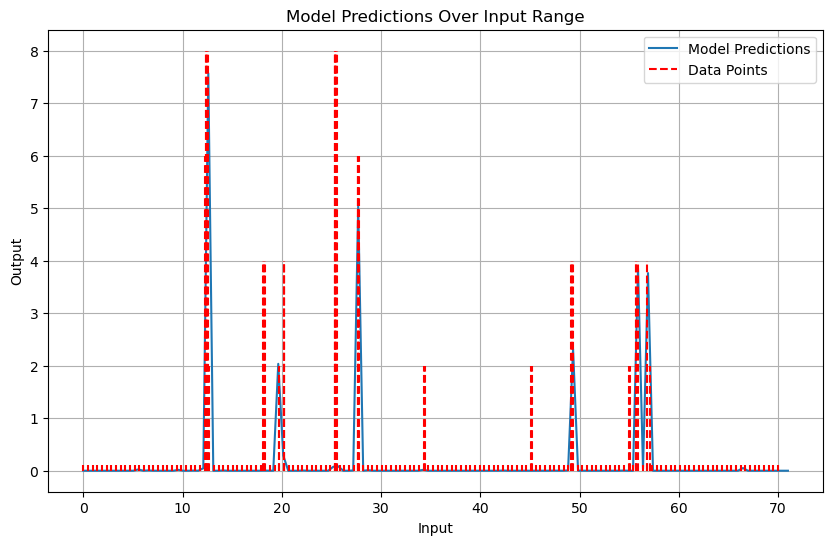

In [ ]:
# 11, 10, 4, 0, 13, 15
# good ones: 4=491? , 13=2290, 
selected_user = 4
dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
print(extras["user_id"])
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        if use_variational_nn:
            predictions_list = []
            for _ in range(20):
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                predictions_list.append(predictions)
                #print("variance of states: ", torch.var(states))
            predictions_list = np.stack(predictions_list)
            predictions = np.mean(predictions_list, axis=0)
            var = np.var(predictions_list, axis=0)
            cond = (0.1>var) | (var <.01)
            #predictions = np.where(cond , predictions, 0)


        else:
            state = torch.tensor(variational_means).repeat(len(x_range),1)
            predictions, states = model(state, x_range_tensor, return_new_state=True)
            predictions = predictions.numpy()
            #print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

if use_variational_nn:
    plt.plot(x_range, var, label='variance', color="green")

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

user:  2839
area: 5.035968017578125


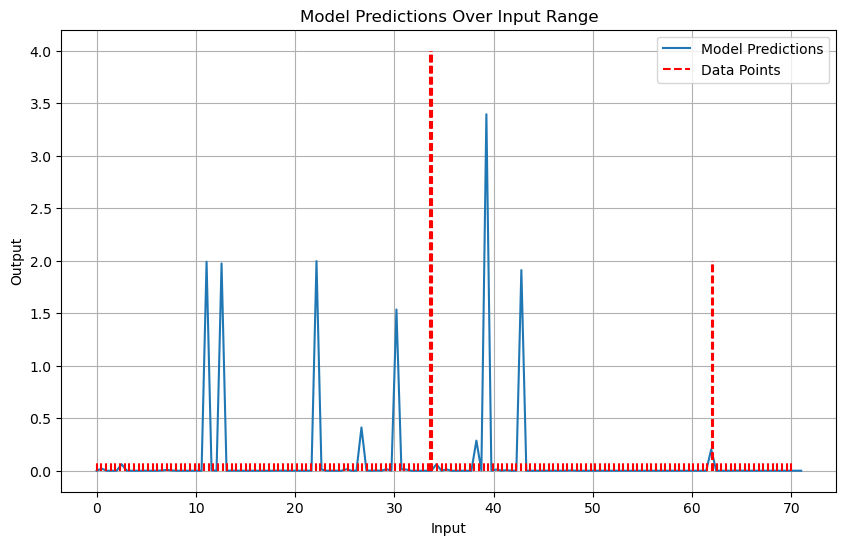

user:  491
area: 24.50389251708984


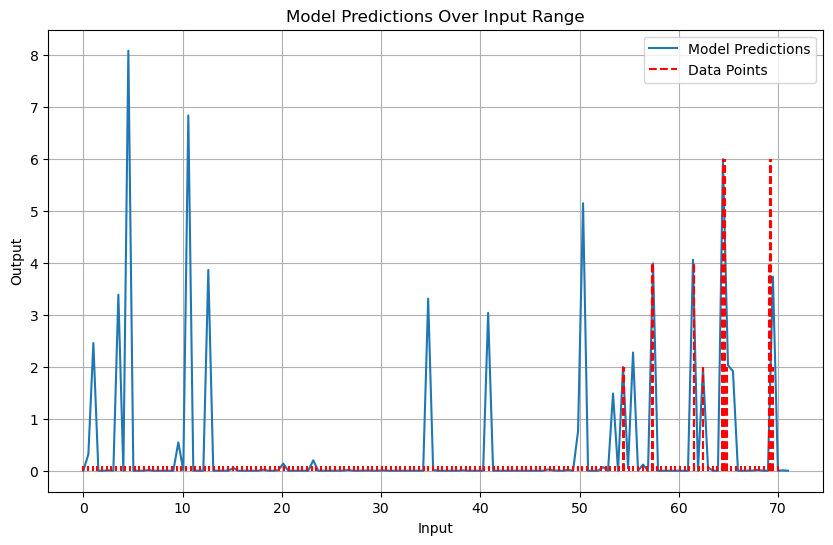

user:  931
area: 12.303961029052735


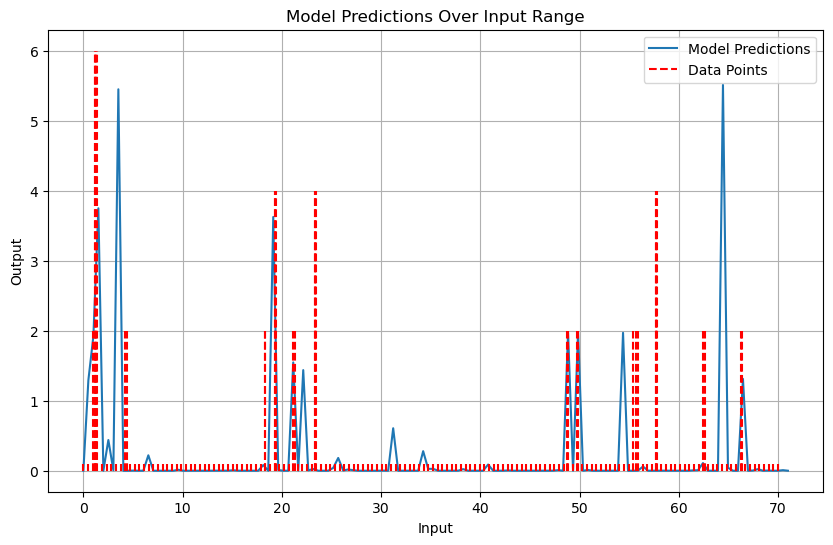

user:  2249
area: 13.055296783447265


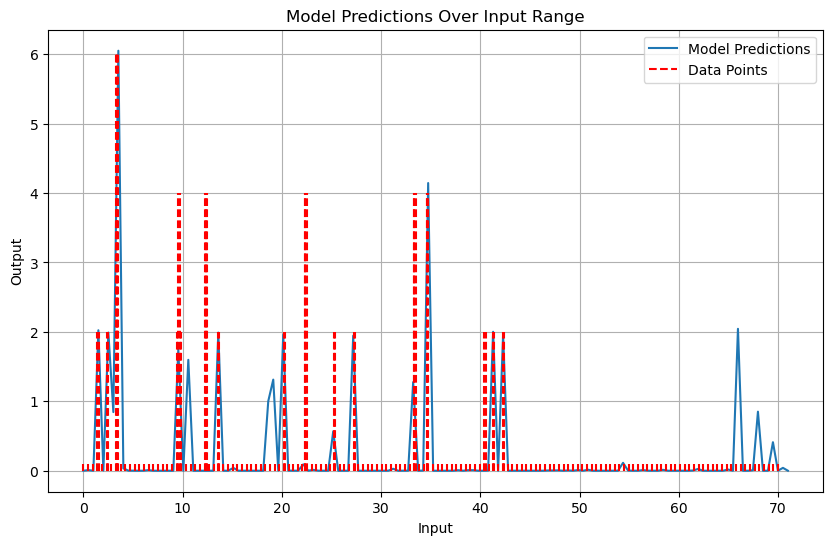

user:  2290
area: 9.103158874511719


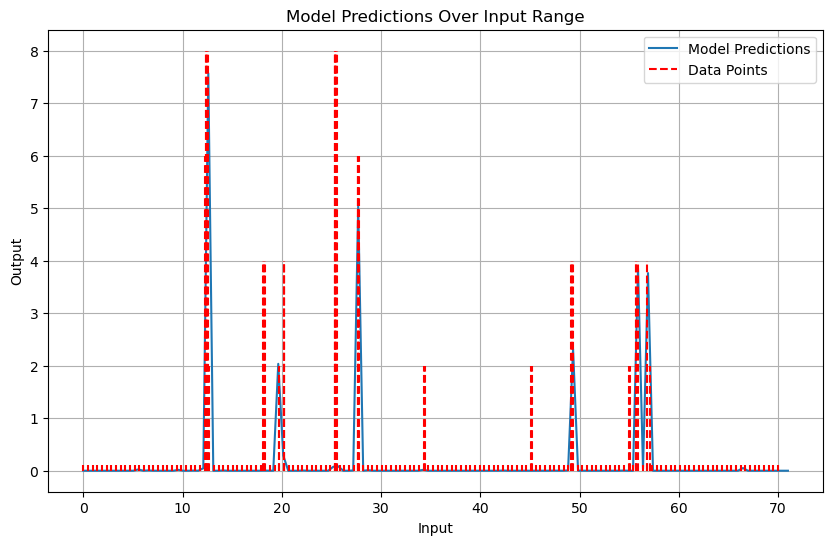

user:  1372
area: 3.0356625366210936


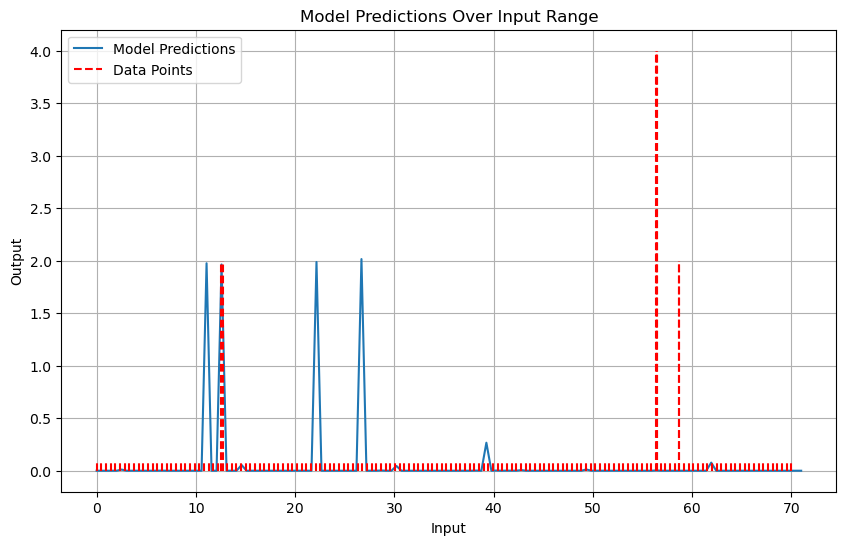

user:  188
area: 8.084042358398436


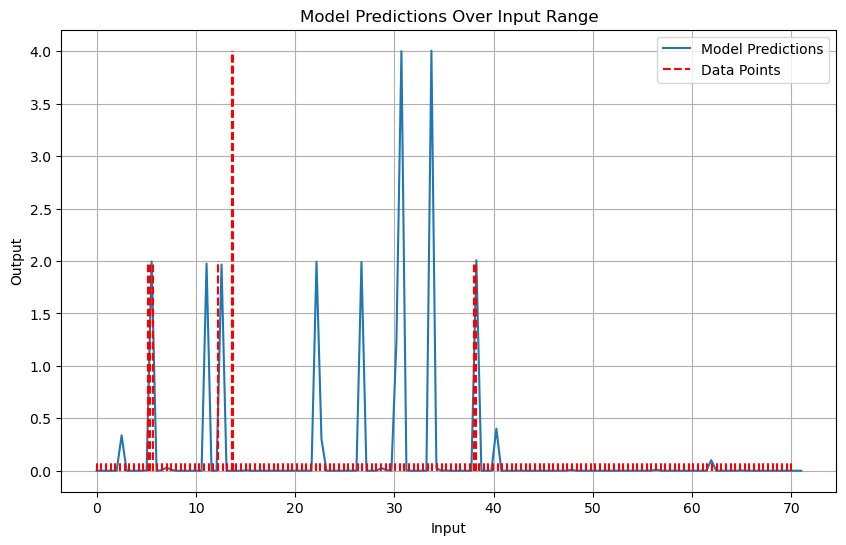

user:  1622
area: 50.22163696289062


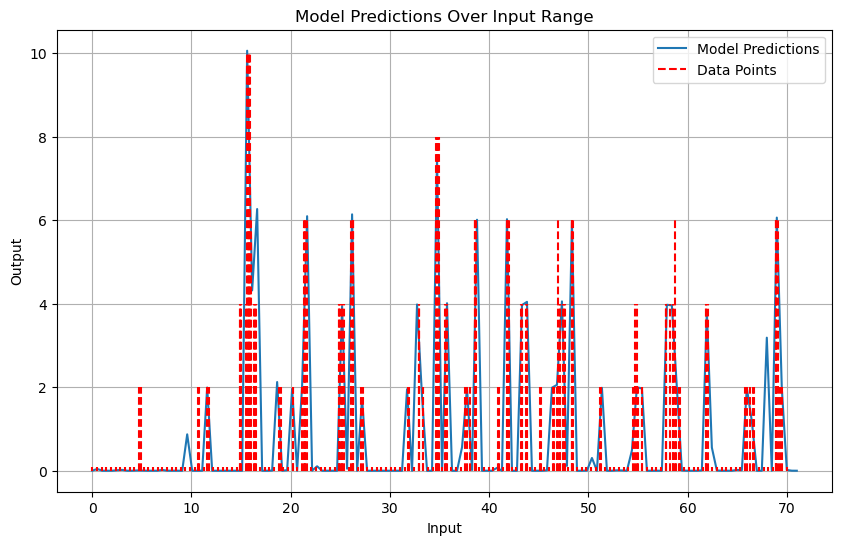

user:  670
area: 11.928570556640624


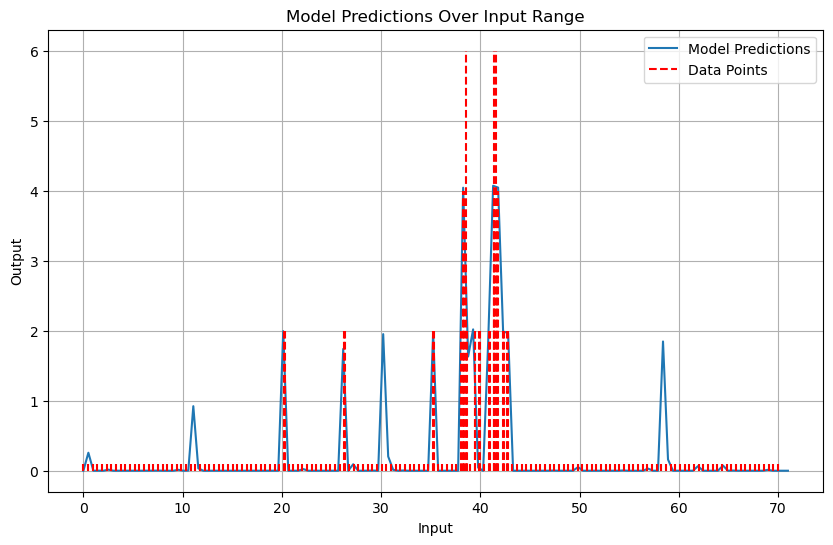

user:  2808
area: 45.48674102783203


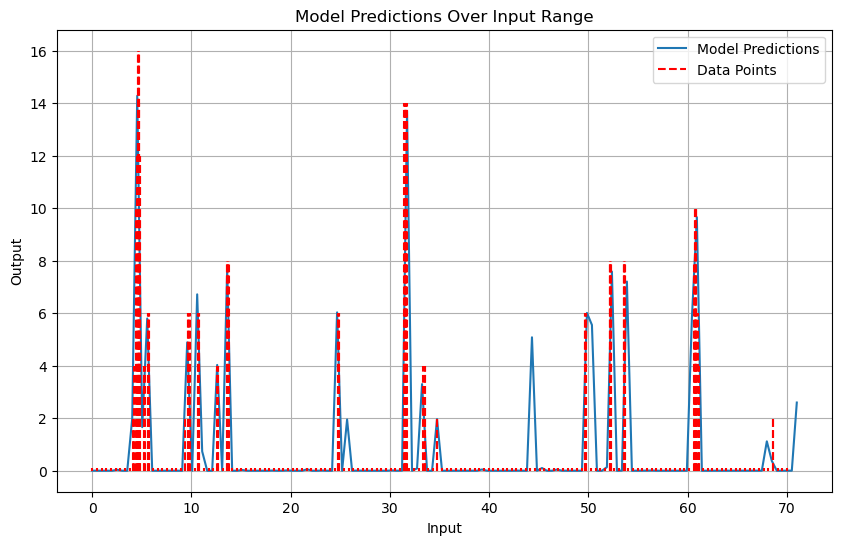

user:  561
area: 5.774352951049805


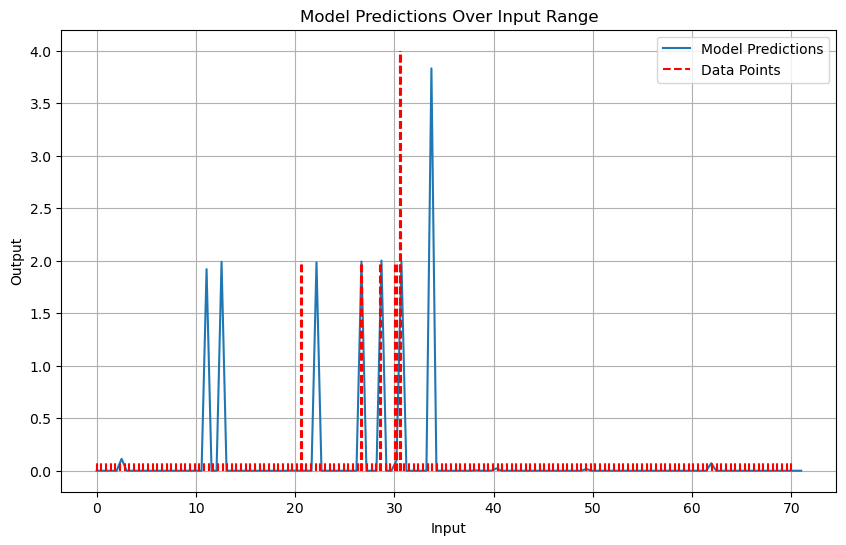

user:  3059
area: 8.387768325805665


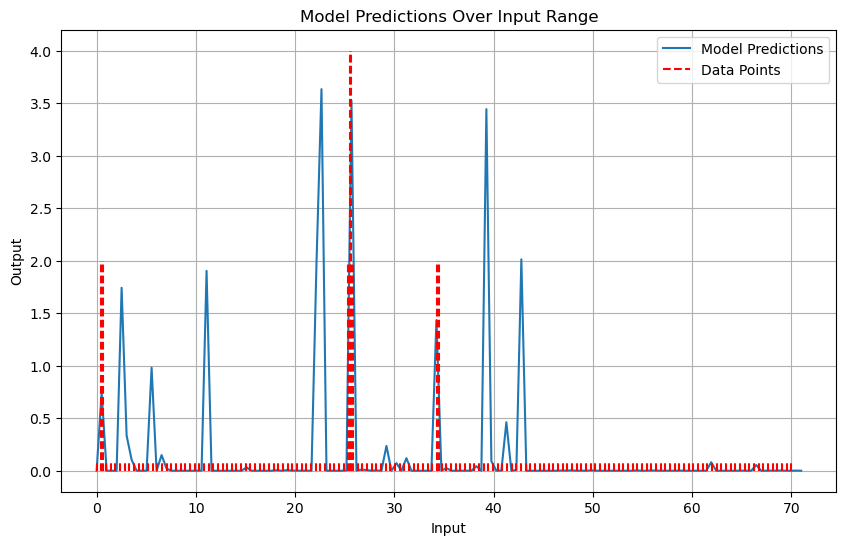

user:  879
area: 54.09426818847656


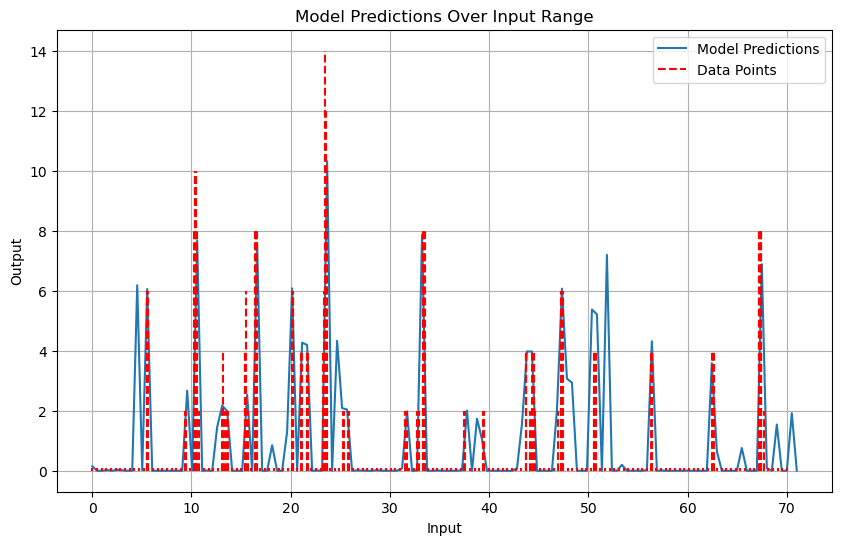

user:  2725
area: 4.83514892578125


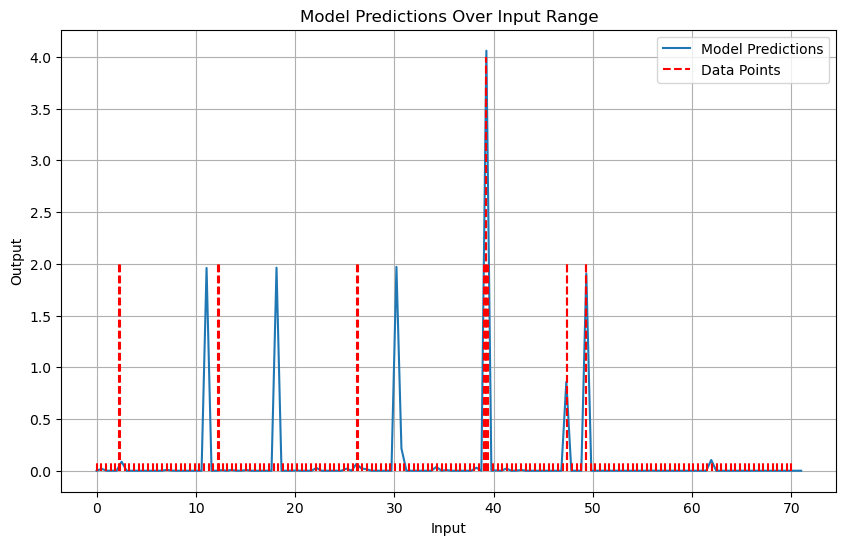

user:  2118
area: 10.324655914306641


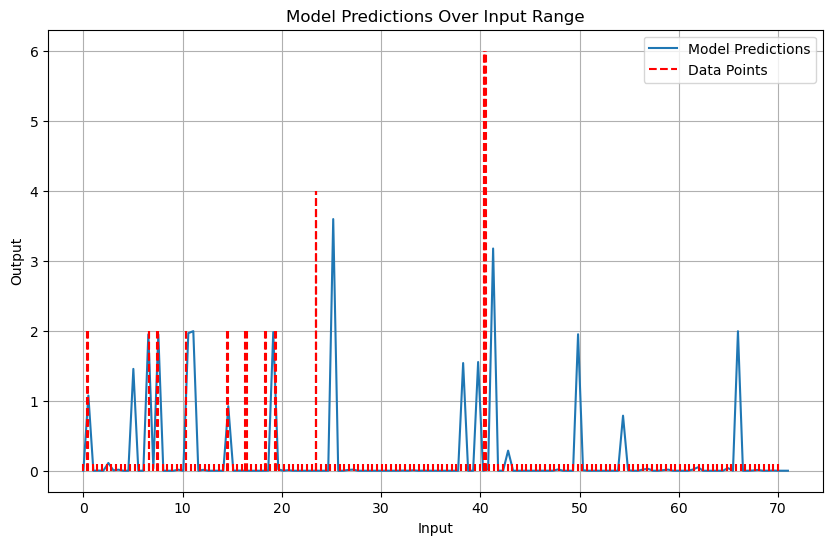

user:  2920
area: 29.50352325439453


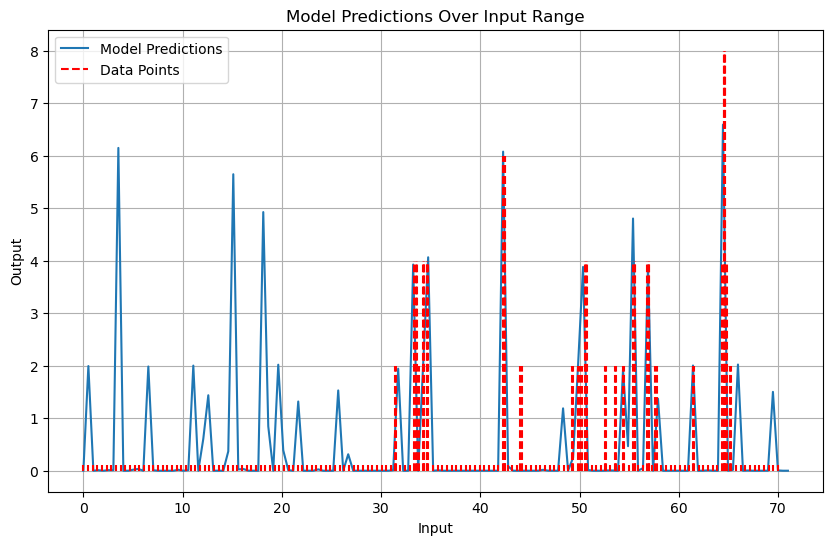

user:  749
area: 8.69445098876953


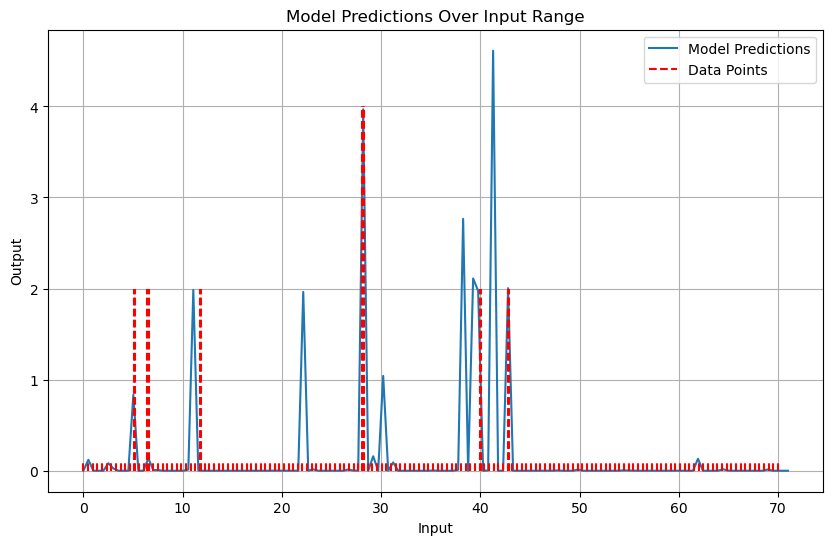

user:  800
area: 4.708906059265137


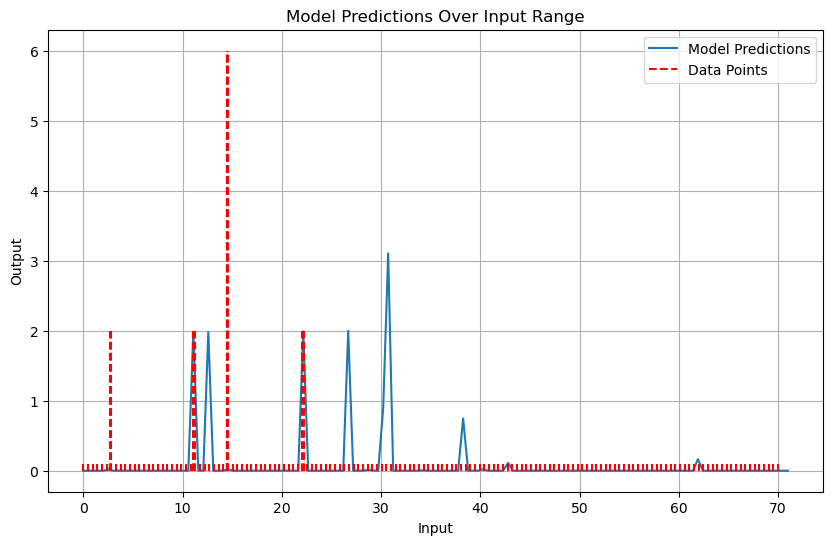

user:  1480
area: 8.40147445678711


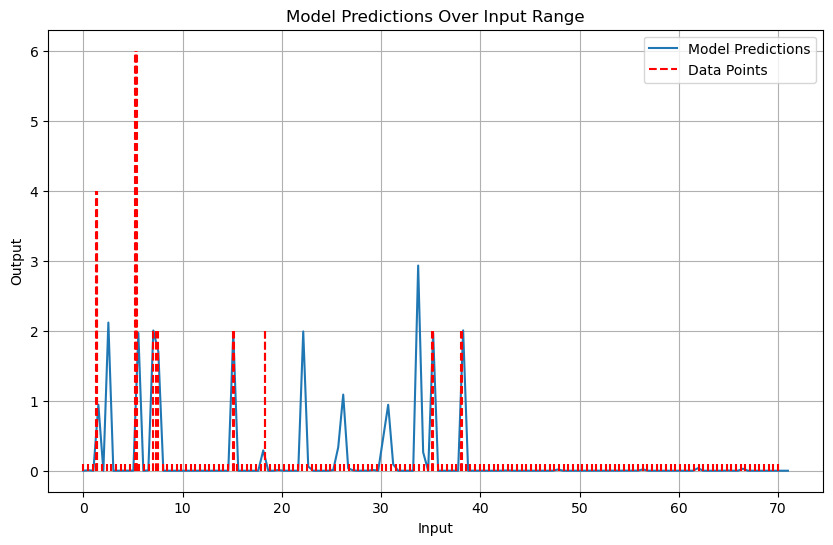

user:  2905
area: 9.251680297851562


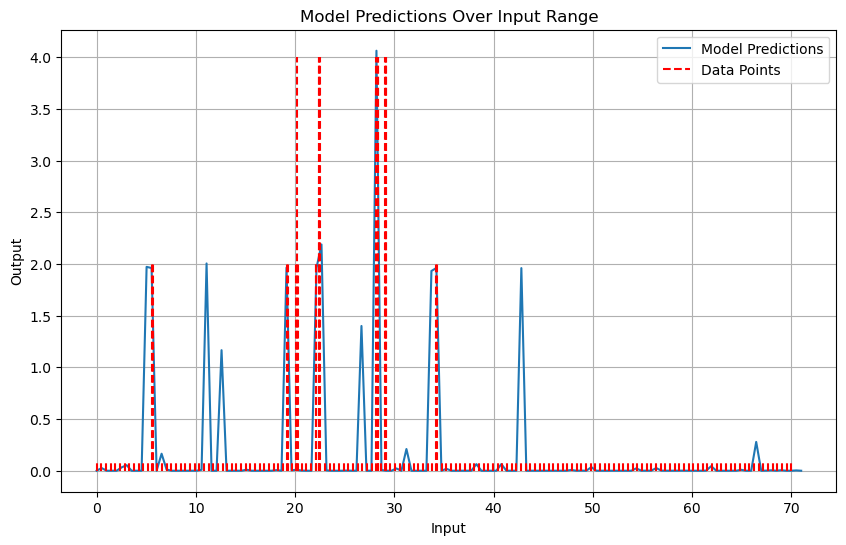

In [ ]:
for selected_user in range(len(dataloader_list)):
    # 11, 10, 4, 0, 13, 15
    # good ones: 4=491? , 13=2290, 
    dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
    print("user: ", extras["user_id"])
    dataset = dataloader.dataset
    x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
    x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
    model.eval()
    with torch.no_grad():
        if model_type == "ode":
            raise NotImplementedError
            state = torch.zeros((1, state_size))

            predictions = []
            for el in x_range:
                out = model(state, el)
                predictions.append(out[0])
        else:
            if use_variational_nn:
                predictions_list = []
                for _ in range(20):
                    state = torch.tensor(variational_means).repeat(len(x_range),1)
                    predictions, states = model(state, x_range_tensor, return_new_state=True)
                    predictions = predictions.numpy()
                    predictions_list.append(predictions)
                    #print("variance of states: ", torch.var(states))
                predictions_list = np.stack(predictions_list)
                predictions = np.mean(predictions_list, axis=0)
                var = np.var(predictions_list, axis=0)
                cond = (0.1>var) | (var <.01)
                #predictions = np.where(cond , predictions, 0)


            else:
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                #print("variance of states: ", torch.var(states))

    print(f"area: {np.sum(predictions)*(72/200)}")
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_range, predictions, label='Model Predictions')

    if use_variational_nn:
        plt.plot(x_range, var, label='variance', color="green")

    for i in range(len(dataset)):
        sample = dataset[i]
        x_pos= sample['timestep'].item()
        height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
        plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

    plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

    #plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Model Predictions Over Input Range')
    plt.legend()
    plt.grid(True)
    plt.show()

3059
variance of states:  tensor(59.6226)
area: 8.387768325805665


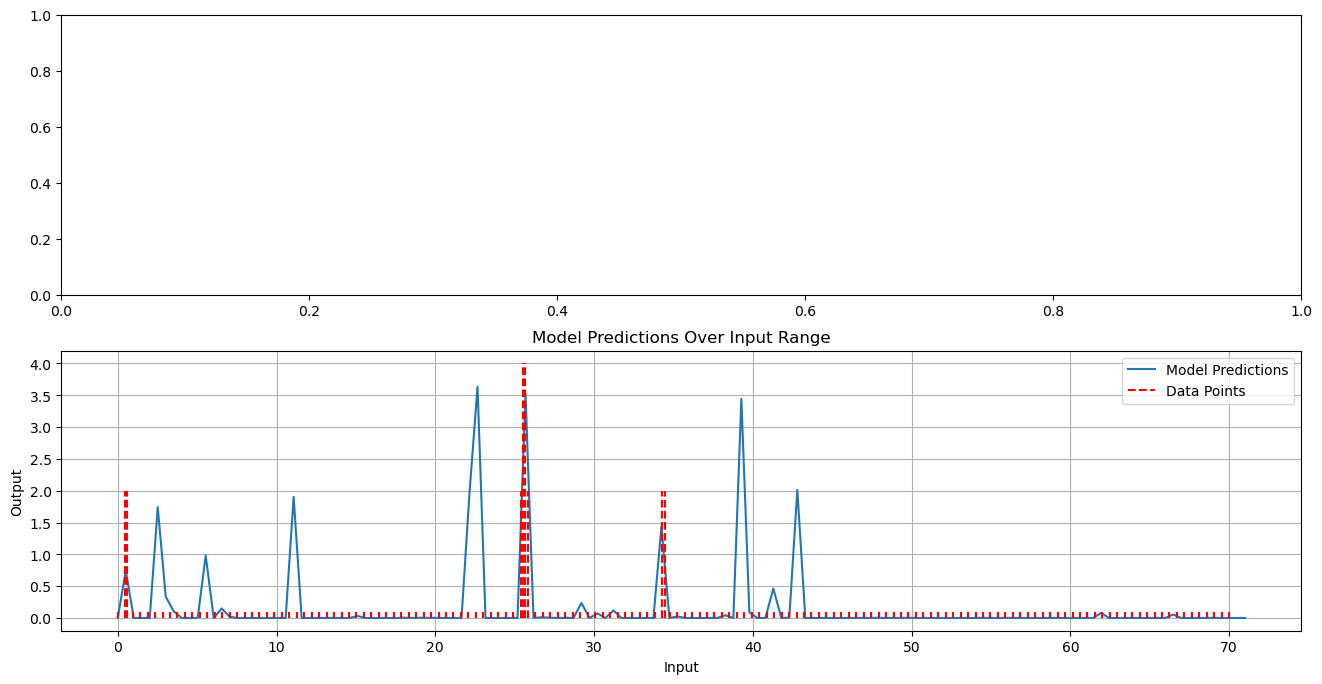

In [ ]:
# ugly version
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

selected_user = 11
dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
print(extras["user_id"])
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        if use_variational_nn:
            predictions_list = []
            for _ in range(20):
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                predictions_list.append(predictions)
                #print("variance of states: ", torch.var(states))
            predictions_list = np.stack(predictions_list)
            predictions = np.mean(predictions_list, axis=0)
            var = np.var(predictions_list, axis=0)
            cond = (0.1>var) | (var <.01)
            predictions = np.where(cond.any() , predictions, 0)


        else:
            state = torch.tensor(variational_means).repeat(len(x_range),1)
            predictions, states = model(state, x_range_tensor, return_new_state=True)
            predictions = predictions.numpy()
            print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.plot(x_range, predictions, label='Model Predictions')

if use_variational_nn:
    axs[0].plot(x_range, var, label='variance', color="green")

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sdfsd  # 30 users below

area: 64.883671875


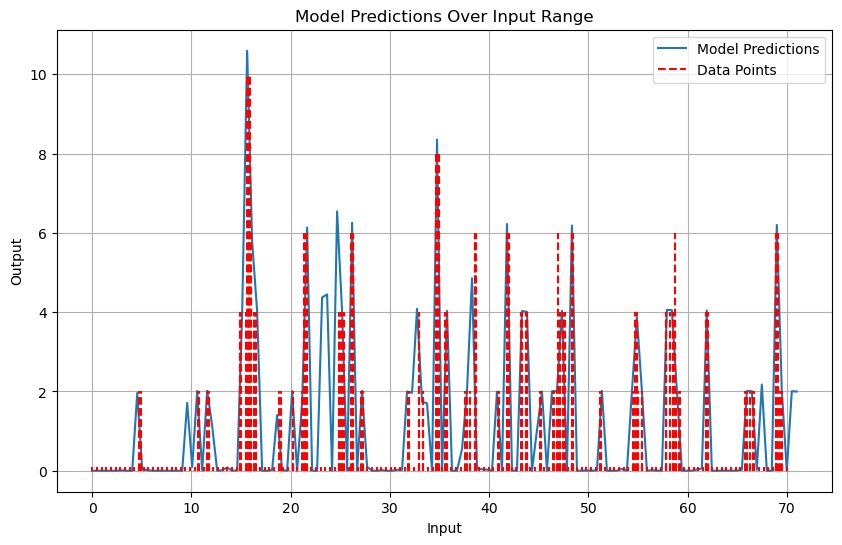

In [ ]:
selected_user = 10
dataloader, variational_means, variational_logvar = dataloader_list[selected_user]
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        state = torch.tensor(variational_means).repeat(len(x_range),1)
        predictions = model(state, x_range_tensor).numpy()

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

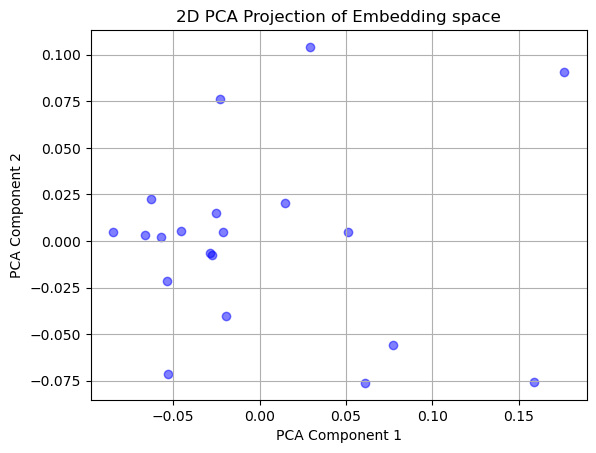

In [35]:
#visualize embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = [data[1] for data in dataloader_list]

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Plot the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Projection of Embedding space')
plt.grid(True)
plt.show()


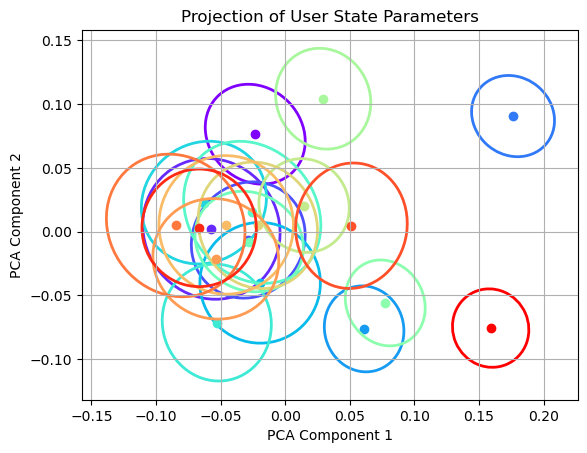

In [52]:
#plot with variances
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

means = [data[1] for data in dataloader_list]
covariances = [np.exp(data[2])*np.eye(state_size) for data in dataloader_list]

colors = plt.cm.rainbow(np.linspace(0, 1, len(means)))

pca = PCA(n_components=2)
reduced_means = pca.fit_transform(means)

def project_covariance(cov, pca):
    return pca.components_ @ (cov ) @ pca.components_.T

reduced_covariances = [project_covariance(cov, pca) for cov in covariances]

# Plotting
fig, ax = plt.subplots()
i =0
for mean, cov in zip(reduced_means, reduced_covariances):
    # Plot the mean
    ax.scatter(mean[0], mean[1], color=colors[i])
    
    # Calculate and plot the 2D Gaussian ellipse
    vals, vecs = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                edgecolor=colors[i], fc='None', lw=2)
    i+=1
    ax.add_patch(ellipse)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('Projection of User State Parameters')
ax.grid(True)
plt.show()


In [ ]:
assdad

## function Approx. sampling

In [ ]:
width=64
use_jump = False
user_state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)]}}
time_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}
            }
jump_dict= {"model_hyp": {"layer_width": [8, 8]}
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict,
                           "jump_model": jump_dict}
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat, noise_size=1)
print(train_model)

all_in_one_model(
  (time_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (jump_model): Jump_Model_ratio(
    (model): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): SiLU()
      (2): Linear(in_features=8, out_f

In [ ]:
steps_per_epoch = len(dataloader_list)

num_epochs = 2001
warmup_period = steps_per_epoch * 1
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)//20
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-6)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [ ]:
from simtrain.utils import weighted_mse_loss

loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [ ]:
train_function_approx_multiple_variational(train_model, path_list, scoring_func=utils.energy_score_loss,
            device=device, user_lr=0.01, user_lr_decay=0.995,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, logging_shift=1,
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, 
            loss_print_interval=25, include_jump=use_jump,
            warmup_period=warmup_period)


  0%|          | 1/2001 [00:02<1:07:38,  2.03s/it]/home/thahit/anaconda3/envs/WWcopy/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1360: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 2/2001 [00:04<1:10:44,  2.12s/it]

epoch: 2 loss_sum_all: 1952.2974, loss_sum_freq: 1930.4888801574707, loss_sum_kl: 21.808491436764598, lr: 0.0009997, userlr: 0.0099500


  1%|▏         | 27/2001 [01:13<1:31:29,  2.78s/it]

epoch: 27 loss_sum_all: 1483.5240, loss_sum_freq: 1464.1889343261719, loss_sum_kl: 19.335000231862068, lr: 0.0008419, userlr: 0.0087781


  3%|▎         | 52/2001 [02:22<1:28:23,  2.72s/it]

epoch: 52 loss_sum_all: 1302.9976, loss_sum_freq: 1225.5569953918457, loss_sum_kl: 77.44064104557037, lr: 0.0004840, userlr: 0.0077442


  4%|▍         | 77/2001 [03:41<1:43:34,  3.23s/it]

epoch: 77 loss_sum_all: 1129.9726, loss_sum_freq: 1042.6633739471436, loss_sum_kl: 87.30925261974335, lr: 0.0001358, userlr: 0.0068321


  5%|▌         | 102/2001 [04:48<1:24:07,  2.66s/it]

epoch: 102 loss_sum_all: 1350.3472, loss_sum_freq: 1272.8707466125488, loss_sum_kl: 77.47641426324844, lr: 0.0009997, userlr: 0.0060274


  6%|▋         | 127/2001 [05:55<1:23:59,  2.69s/it]

epoch: 127 loss_sum_all: 1078.6699, loss_sum_freq: 1014.2580327987671, loss_sum_kl: 64.41189640760422, lr: 0.0008419, userlr: 0.0053175


  8%|▊         | 152/2001 [07:11<1:24:03,  2.73s/it]

epoch: 152 loss_sum_all: 984.3574, loss_sum_freq: 929.392825126648, loss_sum_kl: 54.9646130502224, lr: 0.0004840, userlr: 0.0046912


  9%|▉         | 177/2001 [08:19<1:23:27,  2.75s/it]

epoch: 177 loss_sum_all: 936.6179, loss_sum_freq: 882.7461605072021, loss_sum_kl: 53.87177214026451, lr: 0.0001358, userlr: 0.0041387


 10%|█         | 202/2001 [09:26<1:19:56,  2.67s/it]

epoch: 202 loss_sum_all: 978.4248, loss_sum_freq: 929.045135974884, loss_sum_kl: 49.379669308662415, lr: 0.0009997, userlr: 0.0036512


 11%|█▏        | 227/2001 [10:45<1:19:06,  2.68s/it]

epoch: 227 loss_sum_all: 944.3062, loss_sum_freq: 894.4058074951172, loss_sum_kl: 49.90042969584465, lr: 0.0008419, userlr: 0.0032212


 13%|█▎        | 252/2001 [11:53<1:18:22,  2.69s/it]

epoch: 252 loss_sum_all: 924.6456, loss_sum_freq: 875.9442729949951, loss_sum_kl: 48.70133455097675, lr: 0.0004840, userlr: 0.0028418


 14%|█▍        | 277/2001 [13:01<1:17:49,  2.71s/it]

epoch: 277 loss_sum_all: 862.8085, loss_sum_freq: 814.2969055175781, loss_sum_kl: 48.51154273748398, lr: 0.0001358, userlr: 0.0025071


 15%|█▌        | 302/2001 [14:09<1:16:08,  2.69s/it]

epoch: 302 loss_sum_all: 931.0701, loss_sum_freq: 883.543963432312, loss_sum_kl: 47.526144832372665, lr: 0.0009997, userlr: 0.0022118


 16%|█▋        | 327/2001 [15:17<1:15:38,  2.71s/it]

epoch: 327 loss_sum_all: 958.7966, loss_sum_freq: 910.7966394424438, loss_sum_kl: 47.99994510412216, lr: 0.0008419, userlr: 0.0019513


 18%|█▊        | 352/2001 [16:25<1:14:42,  2.72s/it]

epoch: 352 loss_sum_all: 881.4209, loss_sum_freq: 832.1487264633179, loss_sum_kl: 49.27221578359604, lr: 0.0004840, userlr: 0.0017215


 19%|█▉        | 377/2001 [17:33<1:15:23,  2.79s/it]

epoch: 377 loss_sum_all: 808.6149, loss_sum_freq: 760.053395986557, loss_sum_kl: 48.56152656674385, lr: 0.0001358, userlr: 0.0015187


 20%|██        | 402/2001 [18:44<1:21:02,  3.04s/it]

epoch: 402 loss_sum_all: 881.8252, loss_sum_freq: 832.669620513916, loss_sum_kl: 49.15558135509491, lr: 0.0009997, userlr: 0.0013398


 21%|██▏       | 427/2001 [19:45<1:04:01,  2.44s/it]

epoch: 427 loss_sum_all: 957.3687, loss_sum_freq: 908.2661056518555, loss_sum_kl: 49.10260221362114, lr: 0.0008419, userlr: 0.0011820


 23%|██▎       | 452/2001 [20:47<1:03:17,  2.45s/it]

epoch: 452 loss_sum_all: 877.2255, loss_sum_freq: 827.994060754776, loss_sum_kl: 49.23139640688896, lr: 0.0004840, userlr: 0.0010428


 24%|██▍       | 477/2001 [21:48<1:02:28,  2.46s/it]

epoch: 477 loss_sum_all: 765.6647, loss_sum_freq: 716.6378042697906, loss_sum_kl: 49.02684706449509, lr: 0.0001358, userlr: 0.0009200


 25%|██▌       | 502/2001 [22:49<1:01:11,  2.45s/it]

epoch: 502 loss_sum_all: 853.6958, loss_sum_freq: 804.381781578064, loss_sum_kl: 49.31399342417717, lr: 0.0009997, userlr: 0.0008116


 26%|██▋       | 527/2001 [23:51<1:00:22,  2.46s/it]

epoch: 527 loss_sum_all: 882.1216, loss_sum_freq: 832.3101334571838, loss_sum_kl: 49.811467096209526, lr: 0.0008419, userlr: 0.0007160


 28%|██▊       | 552/2001 [24:51<58:15,  2.41s/it]  

epoch: 552 loss_sum_all: 828.3368, loss_sum_freq: 778.3186717033386, loss_sum_kl: 50.01817652583122, lr: 0.0004840, userlr: 0.0006317


 29%|██▉       | 577/2001 [25:58<58:52,  2.48s/it]  

epoch: 577 loss_sum_all: 700.9488, loss_sum_freq: 650.9170718193054, loss_sum_kl: 50.03168800473213, lr: 0.0001358, userlr: 0.0005573


 30%|███       | 602/2001 [26:59<56:51,  2.44s/it]

epoch: 602 loss_sum_all: 786.5032, loss_sum_freq: 736.573887348175, loss_sum_kl: 49.92936476320028, lr: 0.0009997, userlr: 0.0004917


 31%|███▏      | 627/2001 [28:01<56:29,  2.47s/it]

epoch: 627 loss_sum_all: 919.4517, loss_sum_freq: 869.3259582519531, loss_sum_kl: 50.12570684403181, lr: 0.0008419, userlr: 0.0004338


 33%|███▎      | 652/2001 [29:10<1:22:39,  3.68s/it]

epoch: 652 loss_sum_all: 721.1845, loss_sum_freq: 671.1192283630371, loss_sum_kl: 50.06531602144241, lr: 0.0004840, userlr: 0.0003827


 34%|███▍      | 677/2001 [30:15<53:51,  2.44s/it]  

epoch: 677 loss_sum_all: 649.0628, loss_sum_freq: 599.2411236763, loss_sum_kl: 49.82171103358269, lr: 0.0001358, userlr: 0.0003376


 35%|███▌      | 702/2001 [31:16<54:02,  2.50s/it]

epoch: 702 loss_sum_all: 863.0346, loss_sum_freq: 812.7121751308441, loss_sum_kl: 50.32242316752672, lr: 0.0009997, userlr: 0.0002978


 36%|███▋      | 727/2001 [32:17<52:24,  2.47s/it]

epoch: 727 loss_sum_all: 820.7996, loss_sum_freq: 770.2846450805664, loss_sum_kl: 50.51494959741831, lr: 0.0008419, userlr: 0.0002628


 38%|███▊      | 752/2001 [33:33<52:42,  2.53s/it]  

epoch: 752 loss_sum_all: 678.9419, loss_sum_freq: 628.1630156040192, loss_sum_kl: 50.77887099981308, lr: 0.0004840, userlr: 0.0002318


 39%|███▉      | 777/2001 [34:34<49:45,  2.44s/it]

epoch: 777 loss_sum_all: 601.2235, loss_sum_freq: 550.4488773345947, loss_sum_kl: 50.77459263801575, lr: 0.0001358, userlr: 0.0002045


 40%|████      | 802/2001 [35:35<48:58,  2.45s/it]

epoch: 802 loss_sum_all: 756.6454, loss_sum_freq: 705.8597061634064, loss_sum_kl: 50.785681284964085, lr: 0.0009997, userlr: 0.0001804


 41%|████▏     | 827/2001 [36:37<47:57,  2.45s/it]

epoch: 827 loss_sum_all: 704.6360, loss_sum_freq: 653.6774315834045, loss_sum_kl: 50.95857855677605, lr: 0.0008419, userlr: 0.0001592


 43%|████▎     | 852/2001 [38:13<1:28:32,  4.62s/it]

epoch: 852 loss_sum_all: 680.0261, loss_sum_freq: 629.0523157119751, loss_sum_kl: 50.9738350585103, lr: 0.0004840, userlr: 0.0001404


 44%|████▍     | 877/2001 [39:42<1:04:36,  3.45s/it]

epoch: 877 loss_sum_all: 593.0257, loss_sum_freq: 542.0363163948059, loss_sum_kl: 50.98942584171891, lr: 0.0001358, userlr: 0.0001239


 45%|████▌     | 902/2001 [41:07<49:29,  2.70s/it]  

epoch: 902 loss_sum_all: 692.5670, loss_sum_freq: 641.6616125106812, loss_sum_kl: 50.90536852553487, lr: 0.0009997, userlr: 0.0001093


 46%|████▋     | 927/2001 [42:20<47:41,  2.66s/it]

epoch: 927 loss_sum_all: 768.4907, loss_sum_freq: 717.6461420059204, loss_sum_kl: 50.84453696385026, lr: 0.0008419, userlr: 0.0000964


 48%|████▊     | 952/2001 [43:25<43:20,  2.48s/it]

epoch: 952 loss_sum_all: 796.4654, loss_sum_freq: 745.5993189811707, loss_sum_kl: 50.86608701199293, lr: 0.0004840, userlr: 0.0000851


 49%|████▉     | 977/2001 [44:36<49:27,  2.90s/it]  

epoch: 977 loss_sum_all: 573.7627, loss_sum_freq: 522.9210288524628, loss_sum_kl: 50.84164533391595, lr: 0.0001358, userlr: 0.0000750


 50%|█████     | 1002/2001 [45:54<50:24,  3.03s/it]

epoch: 1002 loss_sum_all: 709.8211, loss_sum_freq: 658.9216613769531, loss_sum_kl: 50.89945124462247, lr: 0.0009997, userlr: 0.0000662


 51%|█████▏    | 1027/2001 [47:08<47:23,  2.92s/it]

epoch: 1027 loss_sum_all: 669.8314, loss_sum_freq: 618.988582611084, loss_sum_kl: 50.84282572194934, lr: 0.0008419, userlr: 0.0000584


 53%|█████▎    | 1052/2001 [48:15<39:04,  2.47s/it]

epoch: 1052 loss_sum_all: 595.1731, loss_sum_freq: 544.3257727622986, loss_sum_kl: 50.847340147942305, lr: 0.0004840, userlr: 0.0000515


 54%|█████▍    | 1077/2001 [49:27<38:11,  2.48s/it]

epoch: 1077 loss_sum_all: 534.7597, loss_sum_freq: 484.00577461719513, loss_sum_kl: 50.753928404301405, lr: 0.0001358, userlr: 0.0000455


 55%|█████▌    | 1102/2001 [50:38<40:47,  2.72s/it]

epoch: 1102 loss_sum_all: 687.5871, loss_sum_freq: 636.8194441795349, loss_sum_kl: 50.76764130964875, lr: 0.0009997, userlr: 0.0000401


 56%|█████▋    | 1127/2001 [51:39<35:17,  2.42s/it]

epoch: 1127 loss_sum_all: 844.7030, loss_sum_freq: 793.967725276947, loss_sum_kl: 50.7352993786335, lr: 0.0008419, userlr: 0.0000354


 58%|█████▊    | 1152/2001 [52:44<36:33,  2.58s/it]

epoch: 1152 loss_sum_all: 645.0281, loss_sum_freq: 594.3411383628845, loss_sum_kl: 50.68695001676679, lr: 0.0004840, userlr: 0.0000312


 59%|█████▉    | 1177/2001 [53:51<35:53,  2.61s/it]

epoch: 1177 loss_sum_all: 488.7115, loss_sum_freq: 438.04643869400024, loss_sum_kl: 50.66509483009577, lr: 0.0001358, userlr: 0.0000275


 60%|██████    | 1202/2001 [54:55<33:51,  2.54s/it]

epoch: 1202 loss_sum_all: 865.2455, loss_sum_freq: 814.59989798069, loss_sum_kl: 50.64560090750456, lr: 0.0009997, userlr: 0.0000243


 61%|██████▏   | 1227/2001 [55:59<33:02,  2.56s/it]

epoch: 1227 loss_sum_all: 635.7979, loss_sum_freq: 585.1707010269165, loss_sum_kl: 50.62717631086707, lr: 0.0008419, userlr: 0.0000214


 63%|██████▎   | 1252/2001 [57:10<30:58,  2.48s/it]

epoch: 1252 loss_sum_all: 564.2926, loss_sum_freq: 513.6887540817261, loss_sum_kl: 50.603864416480064, lr: 0.0004840, userlr: 0.0000189


 64%|██████▍   | 1277/2001 [58:25<30:32,  2.53s/it]

epoch: 1277 loss_sum_all: 470.5097, loss_sum_freq: 419.9408848285675, loss_sum_kl: 50.568829752504826, lr: 0.0001358, userlr: 0.0000167


 65%|██████▌   | 1302/2001 [59:27<28:36,  2.46s/it]

epoch: 1302 loss_sum_all: 608.1083, loss_sum_freq: 557.5390391349792, loss_sum_kl: 50.56926875561476, lr: 0.0009997, userlr: 0.0000147


 66%|██████▋   | 1327/2001 [1:01:14<41:53,  3.73s/it]  

epoch: 1327 loss_sum_all: 595.4568, loss_sum_freq: 544.9240627288818, loss_sum_kl: 50.53278459608555, lr: 0.0008419, userlr: 0.0000130


 68%|██████▊   | 1352/2001 [1:02:56<38:59,  3.60s/it]  

epoch: 1352 loss_sum_all: 544.7100, loss_sum_freq: 494.1942014694214, loss_sum_kl: 50.51582943275571, lr: 0.0004840, userlr: 0.0000115


 69%|██████▉   | 1377/2001 [1:04:26<36:18,  3.49s/it]

epoch: 1377 loss_sum_all: 468.7139, loss_sum_freq: 418.2093529701233, loss_sum_kl: 50.50452158227563, lr: 0.0001358, userlr: 0.0000101


 70%|███████   | 1402/2001 [1:06:25<36:16,  3.63s/it]

epoch: 1402 loss_sum_all: 622.0393, loss_sum_freq: 571.5338430404663, loss_sum_kl: 50.505504835397005, lr: 0.0009997, userlr: 0.0000089


 71%|███████▏  | 1427/2001 [1:08:14<54:58,  5.75s/it]

epoch: 1427 loss_sum_all: 683.1796, loss_sum_freq: 632.687620639801, loss_sum_kl: 50.49195693433285, lr: 0.0008419, userlr: 0.0000079


 73%|███████▎  | 1452/2001 [1:10:27<37:43,  4.12s/it]

epoch: 1452 loss_sum_all: 556.6213, loss_sum_freq: 506.13883876800537, loss_sum_kl: 50.48250017315149, lr: 0.0004840, userlr: 0.0000069


 74%|███████▍  | 1477/2001 [1:12:20<45:13,  5.18s/it]

epoch: 1477 loss_sum_all: 466.1599, loss_sum_freq: 415.6838300228119, loss_sum_kl: 50.47606983780861, lr: 0.0001358, userlr: 0.0000061


 75%|███████▌  | 1502/2001 [1:14:15<49:51,  5.99s/it]

epoch: 1502 loss_sum_all: 549.6627, loss_sum_freq: 499.1938908100128, loss_sum_kl: 50.468794107437134, lr: 0.0009997, userlr: 0.0000054


 76%|███████▋  | 1527/2001 [1:15:55<28:06,  3.56s/it]

epoch: 1527 loss_sum_all: 572.3997, loss_sum_freq: 521.9353313446045, loss_sum_kl: 50.46440691873431, lr: 0.0008419, userlr: 0.0000048


 78%|███████▊  | 1552/2001 [1:17:24<26:21,  3.52s/it]

epoch: 1552 loss_sum_all: 541.5261, loss_sum_freq: 491.0674800872803, loss_sum_kl: 50.458648793399334, lr: 0.0004840, userlr: 0.0000042


 79%|███████▉  | 1577/2001 [1:18:58<25:00,  3.54s/it]

epoch: 1577 loss_sum_all: 451.5610, loss_sum_freq: 401.10750675201416, loss_sum_kl: 50.453494153916836, lr: 0.0001358, userlr: 0.0000037


 80%|████████  | 1602/2001 [1:20:30<23:07,  3.48s/it]

epoch: 1602 loss_sum_all: 606.3062, loss_sum_freq: 555.8564267158508, loss_sum_kl: 50.44976810738444, lr: 0.0009997, userlr: 0.0000033


 81%|████████▏ | 1627/2001 [1:22:14<25:13,  4.05s/it]

epoch: 1627 loss_sum_all: 663.3950, loss_sum_freq: 612.9511790275574, loss_sum_kl: 50.44384519010782, lr: 0.0008419, userlr: 0.0000029


 83%|████████▎ | 1652/2001 [1:23:48<20:34,  3.54s/it]

epoch: 1652 loss_sum_all: 555.8937, loss_sum_freq: 505.45216941833496, loss_sum_kl: 50.441515039652586, lr: 0.0004840, userlr: 0.0000025


 84%|████████▍ | 1677/2001 [1:25:39<25:53,  4.80s/it]

epoch: 1677 loss_sum_all: 440.8916, loss_sum_freq: 390.4526027441025, loss_sum_kl: 50.439015224575996, lr: 0.0001358, userlr: 0.0000022


 85%|████████▌ | 1702/2001 [1:27:19<17:49,  3.58s/it]

epoch: 1702 loss_sum_all: 558.4859, loss_sum_freq: 508.0496538877487, loss_sum_kl: 50.43627543747425, lr: 0.0009997, userlr: 0.0000020


 86%|████████▋ | 1727/2001 [1:28:48<15:49,  3.47s/it]

epoch: 1727 loss_sum_all: 652.2875, loss_sum_freq: 601.8505926132202, loss_sum_kl: 50.43689937517047, lr: 0.0008419, userlr: 0.0000017


 88%|████████▊ | 1752/2001 [1:30:20<19:53,  4.79s/it]

epoch: 1752 loss_sum_all: 528.2339, loss_sum_freq: 477.7984707355499, loss_sum_kl: 50.4354711920023, lr: 0.0004840, userlr: 0.0000015


 89%|████████▉ | 1777/2001 [1:32:06<13:15,  3.55s/it]

epoch: 1777 loss_sum_all: 422.3771, loss_sum_freq: 371.94490599632263, loss_sum_kl: 50.43216575309634, lr: 0.0001358, userlr: 0.0000014


 90%|█████████ | 1802/2001 [1:33:34<11:50,  3.57s/it]

epoch: 1802 loss_sum_all: 493.0266, loss_sum_freq: 442.5963718891144, loss_sum_kl: 50.43019833043218, lr: 0.0009997, userlr: 0.0000012


 91%|█████████▏| 1827/2001 [1:35:02<10:19,  3.56s/it]

epoch: 1827 loss_sum_all: 611.4338, loss_sum_freq: 561.0050761699677, loss_sum_kl: 50.428723737597466, lr: 0.0008419, userlr: 0.0000011


 93%|█████████▎| 1852/2001 [1:36:29<08:17,  3.34s/it]

epoch: 1852 loss_sum_all: 493.4150, loss_sum_freq: 442.9878897666931, loss_sum_kl: 50.42708187922835, lr: 0.0004840, userlr: 0.0000009


 94%|█████████▍| 1877/2001 [1:37:49<07:59,  3.87s/it]

epoch: 1877 loss_sum_all: 424.3005, loss_sum_freq: 373.87472796440125, loss_sum_kl: 50.42579936236143, lr: 0.0001358, userlr: 0.0000008


 95%|█████████▌| 1902/2001 [1:39:13<05:30,  3.34s/it]

epoch: 1902 loss_sum_all: 550.4799, loss_sum_freq: 500.0564213991165, loss_sum_kl: 50.423442386090755, lr: 0.0009997, userlr: 0.0000007


 96%|█████████▋| 1927/2001 [1:40:40<04:04,  3.31s/it]

epoch: 1927 loss_sum_all: 548.7456, loss_sum_freq: 498.32280564308167, loss_sum_kl: 50.422762267291546, lr: 0.0008419, userlr: 0.0000006


 98%|█████████▊| 1952/2001 [1:42:13<03:48,  4.67s/it]

epoch: 1952 loss_sum_all: 483.7586, loss_sum_freq: 433.33650636672974, loss_sum_kl: 50.42207645624876, lr: 0.0004840, userlr: 0.0000006


 99%|█████████▉| 1977/2001 [1:43:54<01:51,  4.67s/it]

epoch: 1977 loss_sum_all: 399.1410, loss_sum_freq: 348.7202501296997, loss_sum_kl: 50.42077834159136, lr: 0.0001358, userlr: 0.0000005


100%|██████████| 2001/2001 [1:45:37<00:00,  3.17s/it]

epoch: 2001 loss_sum_all: 377.9445, loss_sum_freq: 327.5250552892685, loss_sum_kl: 50.41939586400986, lr: 0.0010000, userlr: 0.0000004


[(0, 1952.2973747253418, 1930.4888801574707, 21.808491436764598),
 (25, 1483.5239524841309, 1464.1889343261719, 19.335000231862068),
 (50, 1302.9976482391357, 1225.5569953918457, 77.44064104557037),
 (75, 1129.972635269165, 1042.6633739471436, 87.30925261974335),
 (100, 1350.3471603393555, 1272.8707466125488, 77.47641426324844),
 (125, 1078.6699314117432, 1014.2580327987671, 64.41189640760422),
 (150, 984.357442855835, 929.392825126648, 54.9646130502224),
 (175, 936.6179351806641, 882.7461605072021, 53.87177214026451),
 (200, 978.4247961044312, 929.045135974884, 49.379669308662415),
 (225, 944.3062419891357, 894.4058074951172, 49.90042969584465),
 (250, 924.6455965042114, 875.9442729949951, 48.70133455097675),
 (275, 862.8084506988525, 814.2969055175781, 48.51154273748398),
 (300, 931.0701055526733, 883.543963432312, 47.526144832372665),
 (325, 958.7965965270996, 910.7966394424438, 47.99994510412216),
 (350, 881.420937538147, 832.1487264633179, 49.27221578359604),
 (375, 808.6149282455

### visualization

In [ ]:
def simulate_single_forced_function_approx(model, user_data, state_size, use_jump=False,
                                           timecheat=False, num_tries=20, state=None):
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    path, variational_means, variational_logvar, reaction_ratio, extra = user_data
    results = []
    with torch.no_grad():
        for interaction_id in range(len(path)):
            timestep = path[interaction_id]
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            last_t = timestep
            state = model.get_new_state(state, torch.tensor([[timestep]]))
            if use_jump:
                    reactions_ratio_tensor = torch.tensor(reaction_ratio[interaction_id], dtype=torch.float32).view(1,-1)
                    state = model.jump(state, reactions_ratio_tensor)
    
    return results

def simulate_single_function_approx(model, state_size, num_events=10, 
            timecheat=False, num_tries=20, state=None, jump_data=None,):
    #if use_jump:
    #    raise NotImplementedError# what should this do?
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for interaction_id in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            selected = torch.mean(current_pred)
            results.append(selected)
            last_t = selected
            state = model.get_new_state(state, torch.tensor([[selected]]))
            
            if jump_data:
                reactions_ratio_tensor = torch.tensor(jump_data[interaction_id], dtype=torch.float32).view(1,-1)
                state = model.jump(state, reactions_ratio_tensor)
    
    return results

In [ ]:
user_id = 8
sample_path = path_list[user_id]
state = torch.tensor([sample_path[1]])
len(sample_path[0]), state

(5, tensor([[ 0.0201, -0.1089, -0.0716,  0.0882]]))

In [ ]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    simulate_single_forced_function_approx, user_data=sample_path,state=state,
                              num_tries=100, timecheat=timecheat, state_size=state_size,
                              use_jump=use_jump)
simulate_single_partial_function_approx = partial(
    simulate_single_function_approx, num_events =len(sample_path), state=state,
                              num_tries=100, timecheat=timecheat, state_size=state_size,
                              jump_data=sample_path[3])

In [ ]:
# intensity
example_out_forced = simulate_single_partial_forced_function_approx(train_model)
example_out = simulate_single_partial_function_approx(train_model)
example_out_forced

[tensor(5.4820),
 tensor(12.5777),
 tensor(12.4617),
 tensor(13.8430),
 tensor(13.8894)]

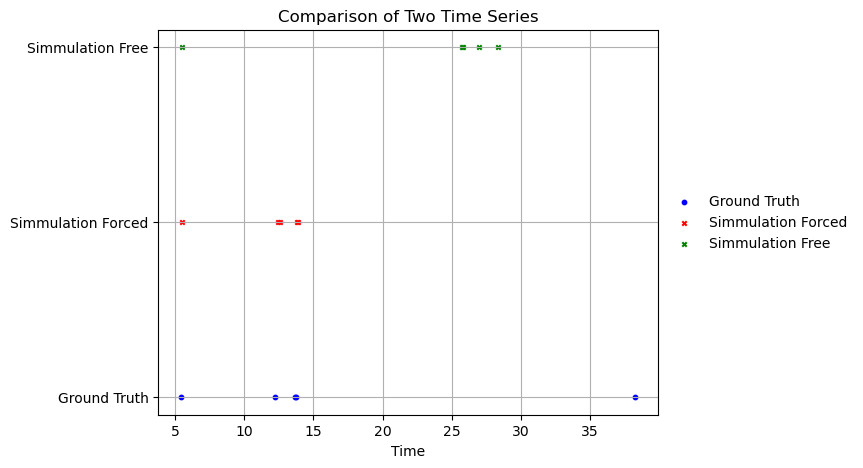

In [ ]:
time_series_1 = sample_path[0] # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


2249


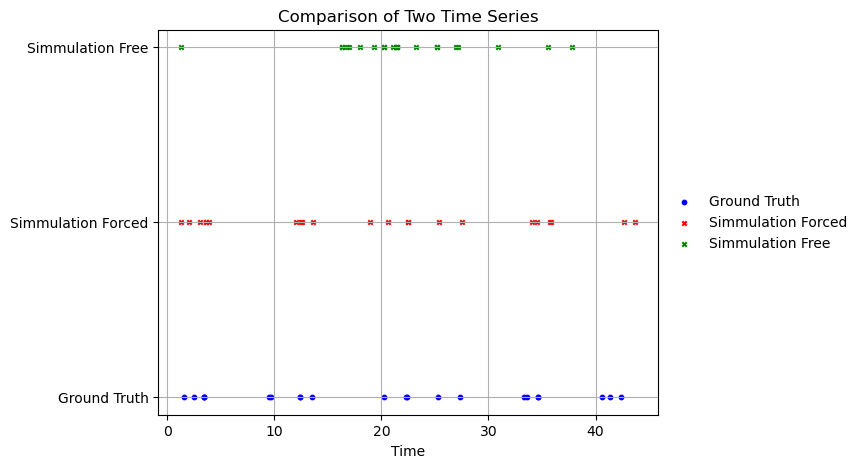

879


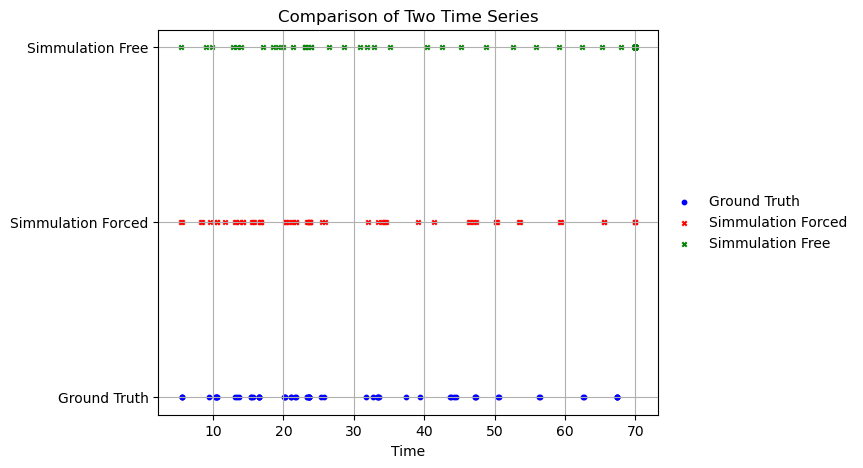

2118


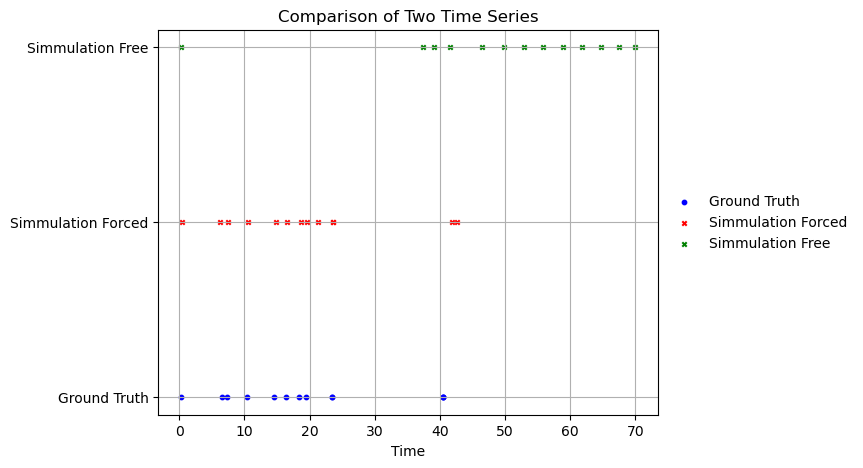

2839


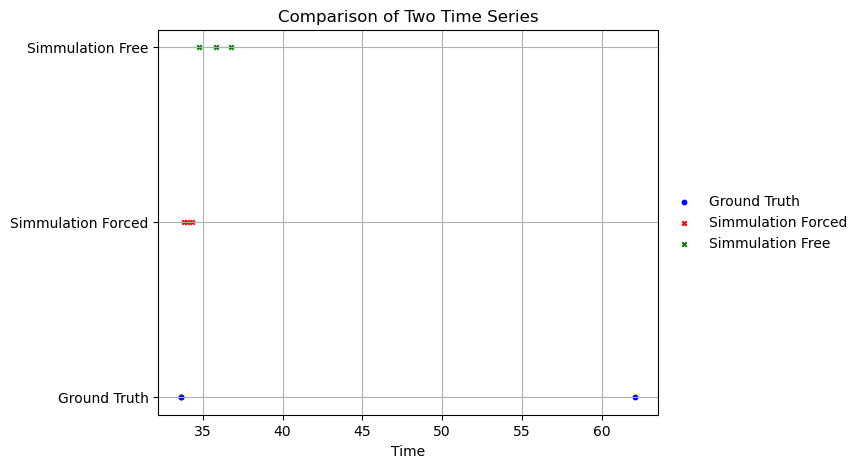

2920


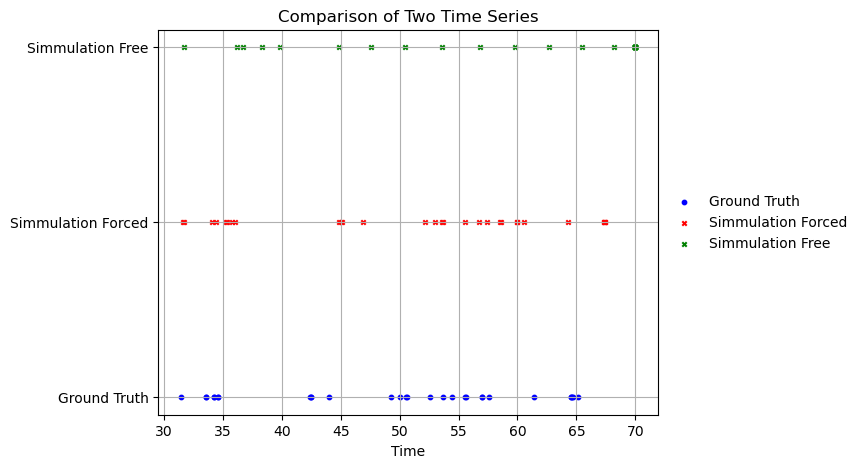

2290


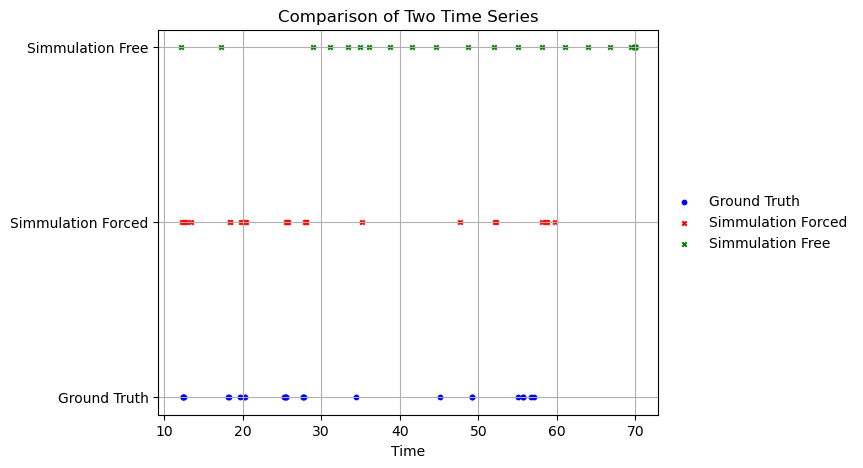

800


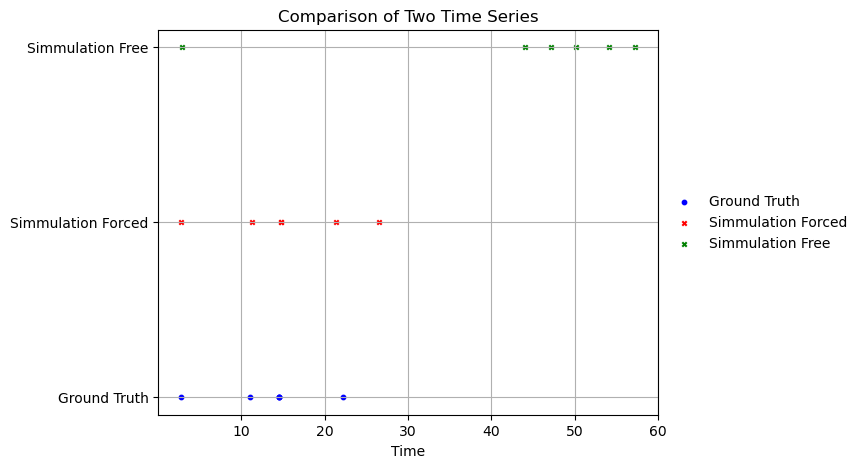

1622


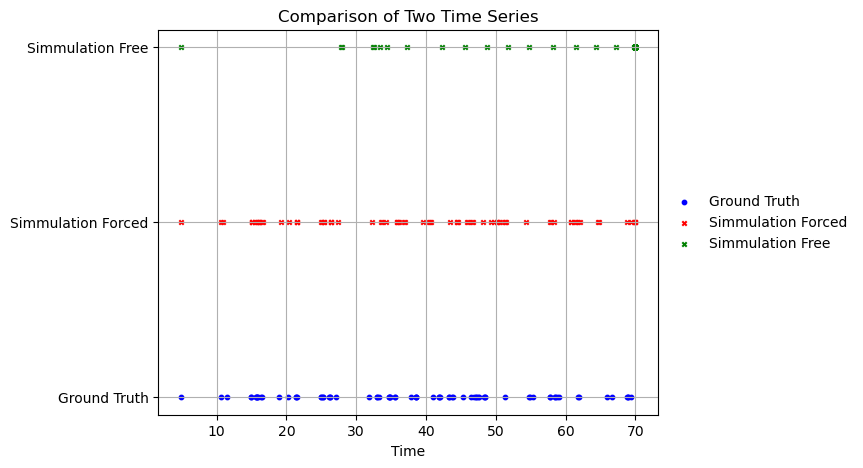

188


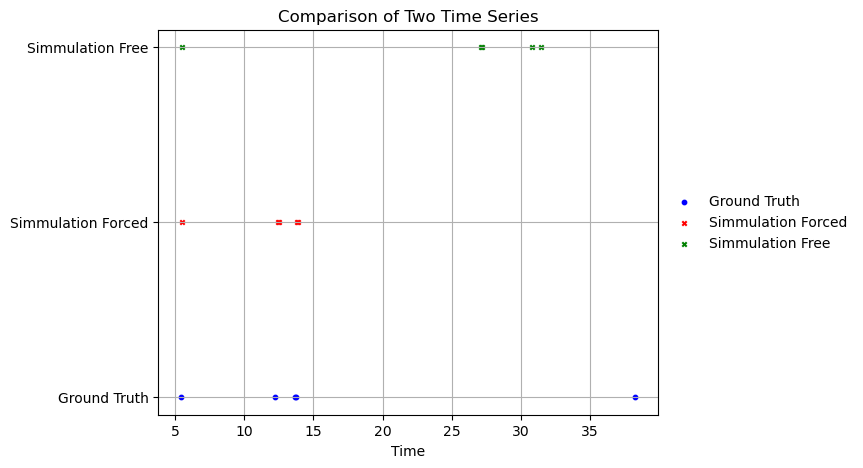

931


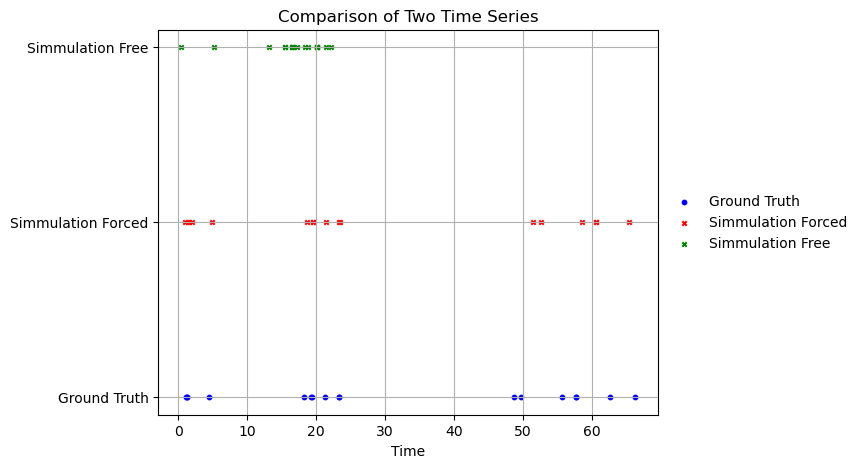

561


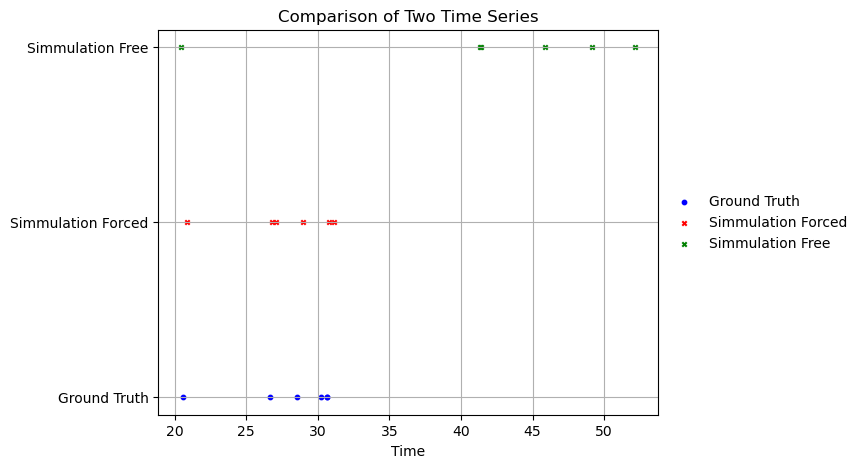

2725


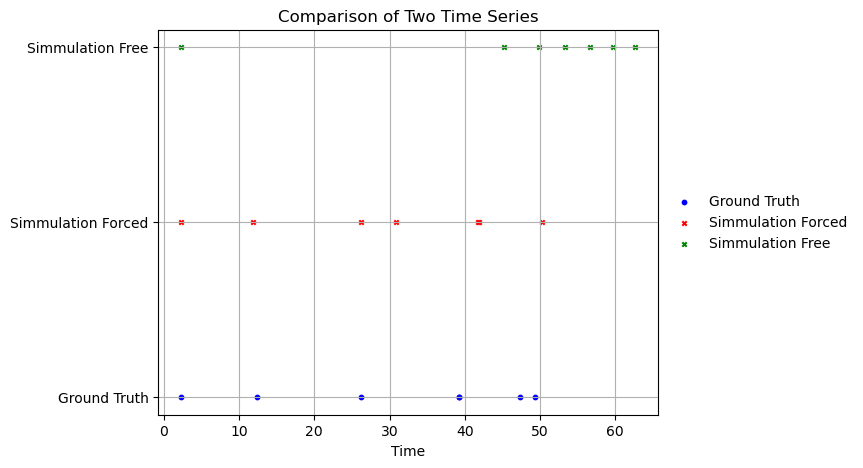

1372


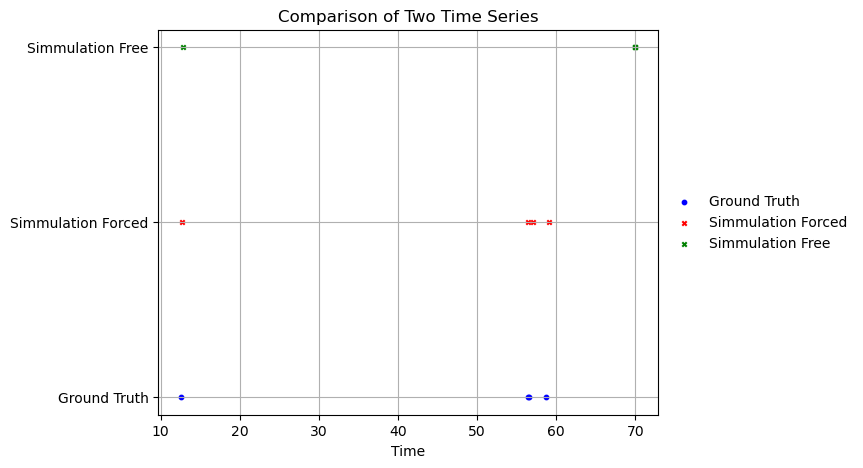

3059


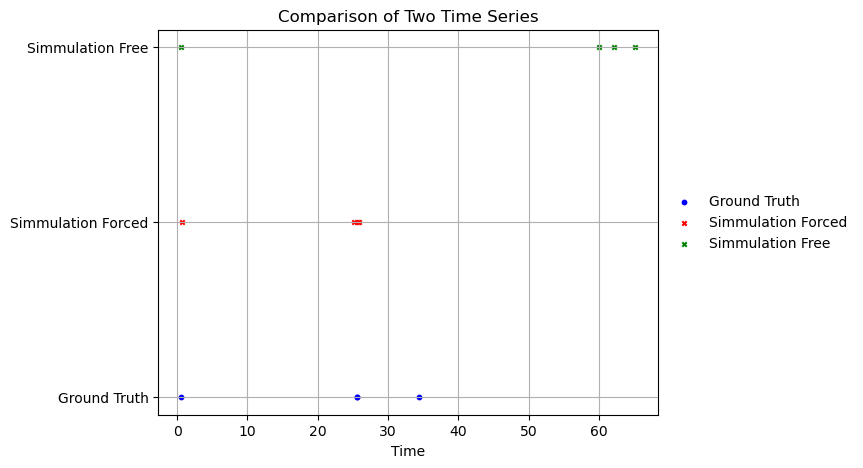

670


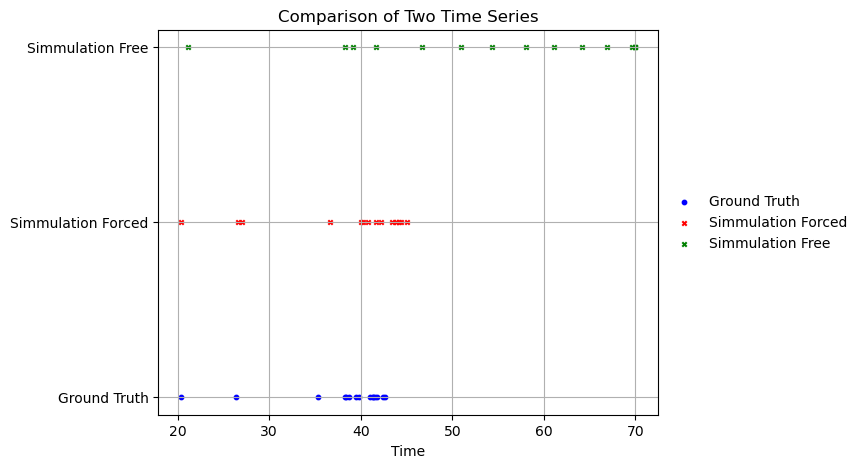

1480


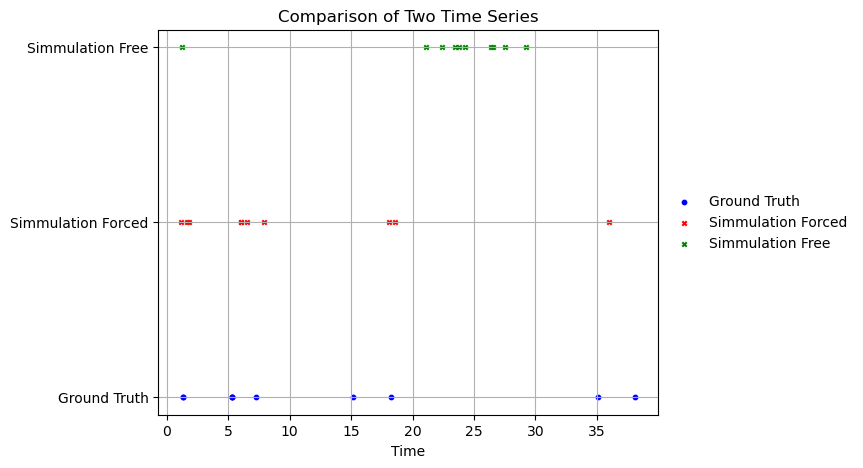

491


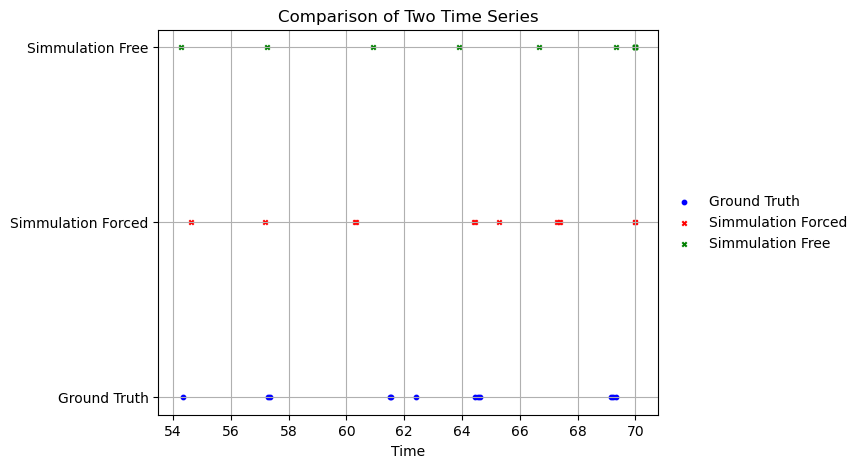

2808


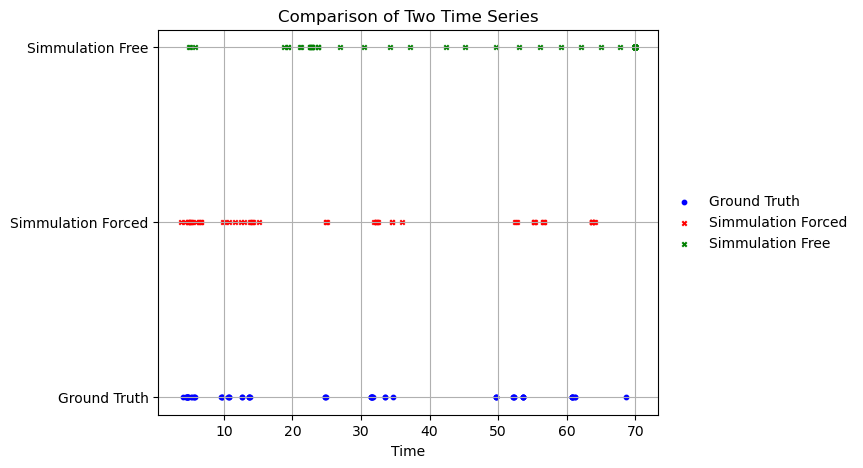

2905


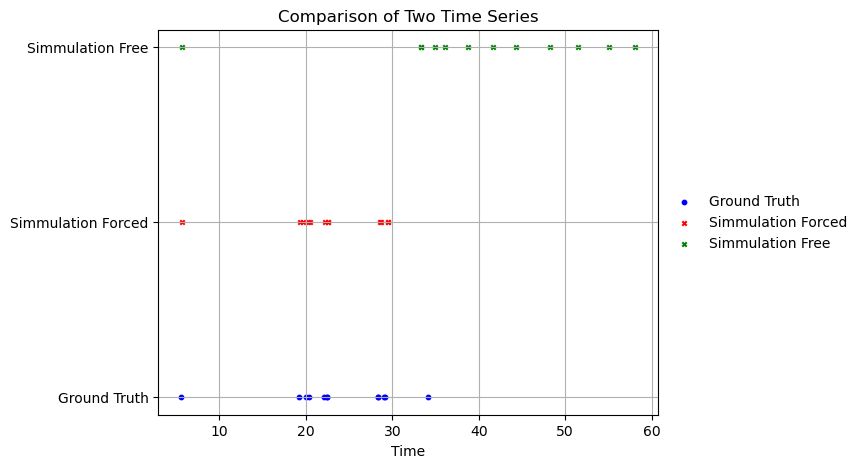

749


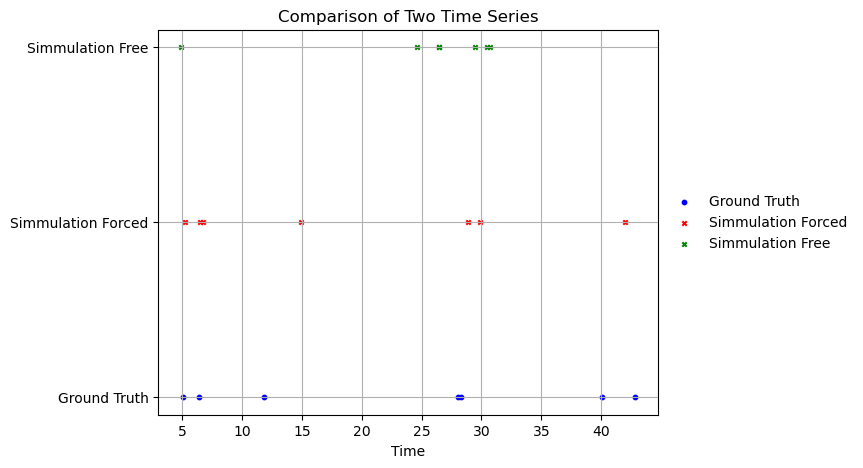

In [ ]:
for ind in range(len(path_list)):
    sample_path = path_list[ind]
    print(sample_path[4]["user_id"])
    state = torch.tensor([sample_path[1]])
    # simpler nn
    simulate_single_partial_forced_function_approx = partial(
        simulate_single_forced_function_approx, user_data=sample_path,state=state,
                                num_tries=100, timecheat=timecheat, state_size=state_size,
                                use_jump=use_jump)
    simulate_single_partial_function_approx = partial(
        simulate_single_function_approx, num_events =len(sample_path[0]), state=state,
                                num_tries=1, timecheat=timecheat, state_size=state_size,
                                jump_data=sample_path[3])
    # intensity
    example_out_forced = simulate_single_partial_forced_function_approx(train_model)
    example_out = simulate_single_partial_function_approx(train_model)

    time_series_1 = sample_path[0] # Timestamps for the first time series
    time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
    time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot the first time series
    ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

    # Plot the second time series
    ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

    ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


    # Add labels, legend, and grid
    ax.set_xlabel('Time')
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
    ax.set_title('Comparison of Two Time Series')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    # Adjust subplot parameters to make room for the legend
    plt.subplots_adjust(right=0.75)
    ax.grid(True)

    # Display the plot
    plt.show()



# Combined Models old

In [ ]:
# parameter dicts
width= 32
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width],
                                        "noise": 0},
                        "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [ ]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
        "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
        "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
        "jump_model": jump_state_dict, "user_params_size": state_size,
        "noise": .01}
model = User_simmulation_Model(hyperparameter_dict)
#model = Conditioned_User_simmulation_Model(hyperparameter_dict)

In [ ]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                 experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2
user_lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([-0.0650], dtype=torch.float64), tensor([0.0293], dtype=torch.float64), tensor([0.0160], dtype=torch.float64), tensor([0.0170], dtype=torch.float64)]
logvar:  [tensor([-1.3569], dtype=torch.float64), tensor([-0.6309], dtype=torch.float64), tensor([-3.0378], dtype=torch.float64), tensor([-1.1676], dtype=torch.float64)]
means:  [tensor([0.5555], dtype=torch.float64), tensor([-0.5281], dtype=torch.float64), tensor([-0.4462], dtype=torch.float64), tensor([-0.5223], dtype=torch.float64)]
logvar:  [tensor([-2.9949], dtype=torch.float64), tensor([-1.3232], dtype=torch.float64), tensor([-2.9254], dtype=torch.float64), tensor([-1.1151], dtype=torch.float64)]
means:  [tensor([0.0046], dtype=torch.float64), tensor([0.1227], dtype=torch.float64), tensor([-0.2567], dtype=torch.float64), tensor([0.1705], dtype=torch.float64)]
logvar:  [tensor([-3.0190], dtype=torch.float64), tensor([-2.8460], dtype=torch.float64), tensor([-4.4657], dtype=torch.float64), tensor([-4.9160], dtype=torch.

: 

In [ ]:
# no negative samples
with torch.autograd.set_detect_anomaly(True):
        train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=kl_weight, user_lr=user_lr, conditioned=conditioned,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func, warmup_period=warmup_period, 
                intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )


  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss_all: 83.185 	loss_base: 10.408 	loss_kl: 11.211 	loss_intensity:  61.566 	log of the loss: 1.92
loss_all: 177.653 	loss_base: 20.356 	loss_kl: 33.775 	loss_intensity:  123.523 	log of the loss: 2.25
loss_all: 329.329 	loss_base: 66.809 	loss_kl: 77.167 	loss_intensity:  185.353 	log of the loss: 2.52
loss_all: 421.758 	loss_base: 78.782 	loss_kl: 105.552 	loss_intensity:  237.423 	log of the loss: 2.63


In [ ]:
adsaf 

NameError: name 'adsaf' is not defined

In [ ]:
train_with_negatives(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
                loss_func=utils.loss_func, loss_func_kl=utils.kl_loss, kl_weight=kl_weight, 
                user_lr=user_lr, optimizer=optimizer, lr_scheduler=lr_scheduler, 
                num_classes=num_interaction_types, logger=utils.logging_func,
                warmup_period=warmup_period, intensity_loss_func=utils.log_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                num_negatives=num_negatives, positive_examples_weight=5,conditioned=conditioned,
                )

  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 10%|█         | 1/10 [03:36<32:32, 216.99s/it]

loss_all: 6022.002 	loss_base: 1665.032 	loss_kl: 1009.140 	loss_intensity:  3347.830 	log of the loss: 3.78


 20%|██        | 2/10 [07:35<30:35, 229.43s/it]

loss_all: 5316.963 	loss_base: 1665.079 	loss_kl: 976.702 	loss_intensity:  2675.182 	log of the loss: 3.73


 30%|███       | 3/10 [11:40<27:37, 236.82s/it]

loss_all: 5213.752 	loss_base: 1665.184 	loss_kl: 948.971 	loss_intensity:  2599.597 	log of the loss: 3.72


 30%|███       | 3/10 [12:24<28:58, 248.32s/it]


KeyboardInterrupt: 

In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.0020], dtype=torch.float64), tensor([0.0003], dtype=torch.float64), tensor([-0.0003], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0076], dtype=torch.float64), tensor([-0.0022], dtype=torch.float64), tensor([0.0018], dtype=torch.float64)]
logvar:  [tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64)]
means:  [tensor([0.0010], dtype=torch.float64), tensor([0.0013], dtype=torch.float64), tensor([-0.0005], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0024], dtype=torch.float64), tensor([0.1395], dtype=torch.float64), tensor([-0.1428], dtype=torch.float64)]
logvar:  [tensor([-0.4619], dtype=torch.float64), tensor([-0.4619], dtype=torch.float64), tensor([-0

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


## visualize

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5020]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5026]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4968]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5004]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4659]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


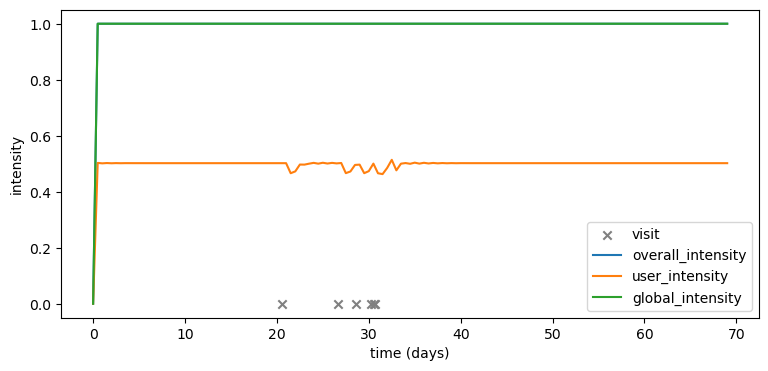

In [ ]:
# conditioned square continouous state + state_int new formulas
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, 
                dataset=dataloader.dataset, User_model = model, use_true_recommendations =True, 
                num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4791]]) 	user_intensity:  tensor([[0.4861]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4793]]) 	user_intensity:  tensor([[0.4862]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4425]]) 	user_intensity:  tensor([[0.4616]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4629]]) 	user_intensity:  tensor([[0.4753]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4884]]) 	user_intensity:  tensor([[0.4922]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


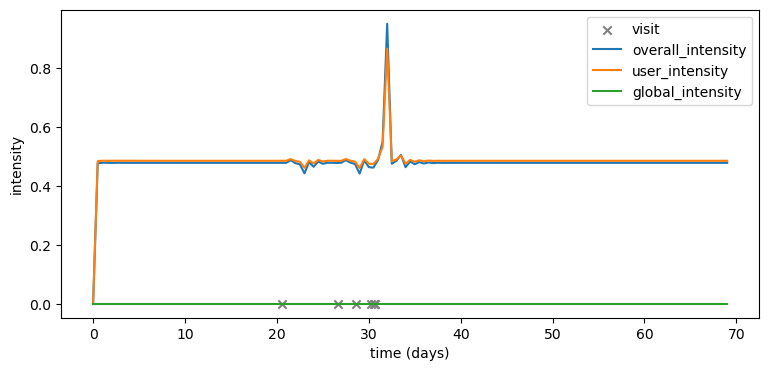

In [ ]:
# conditioned square continouous state + state_int
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.4997]]) 	user_intensity:  tensor([[0.4998]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4988]]) 	user_intensity:  tensor([[0.4992]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4539]]) 	user_intensity:  tensor([[0.4692]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4550]]) 	user_intensity:  tensor([[0.4699]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4708]]) 	user_intensity:  tensor([[0.4805]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


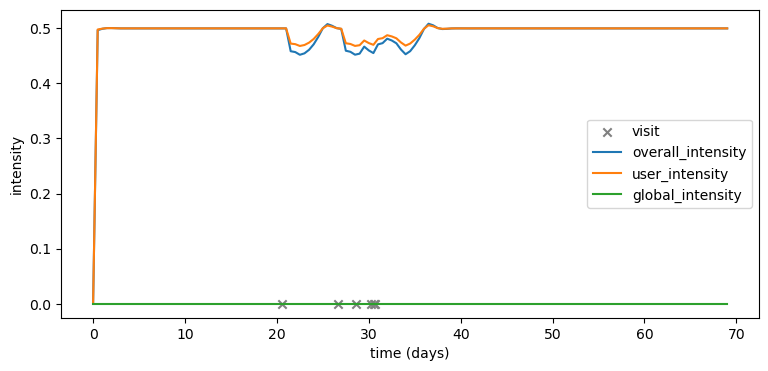

In [ ]:
# conditioned square continouous state
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4913]]) 	user_intensity:  tensor([[0.4942]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5027]]) 	user_intensity:  tensor([[0.5018]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5085]]) 	user_intensity:  tensor([[0.5056]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5214]]) 	user_intensity:  tensor([[0.5143]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5335]]) 	user_intensity:  tensor([[0.5223]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


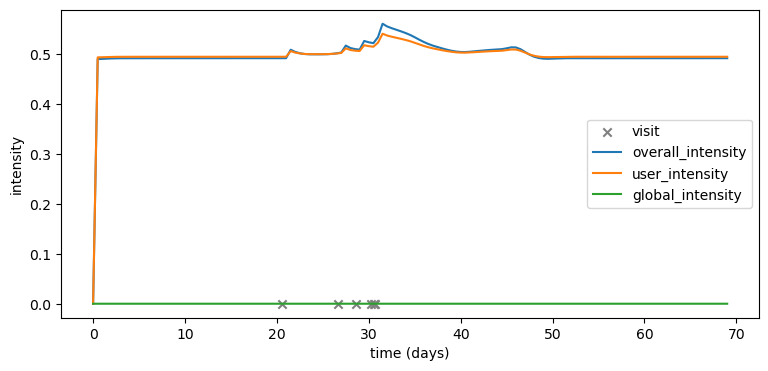

In [ ]:
# conditioned negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4873]]) 	user_intensity:  tensor([[0.4915]]) 	global_intensity:  tensor([4.8434e-29]) 	 before a recommendation.
overall_intensity:  tensor([[0.4734]]) 	user_intensity:  tensor([[0.4822]]) 	global_intensity:  tensor([4.7692e-39]) 	 before a recommendation.
overall_intensity:  tensor([[0.4891]]) 	user_intensity:  tensor([[0.4927]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4924]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[0.4925]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4820]]) 	user_intensity:  tensor([[0.4880]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


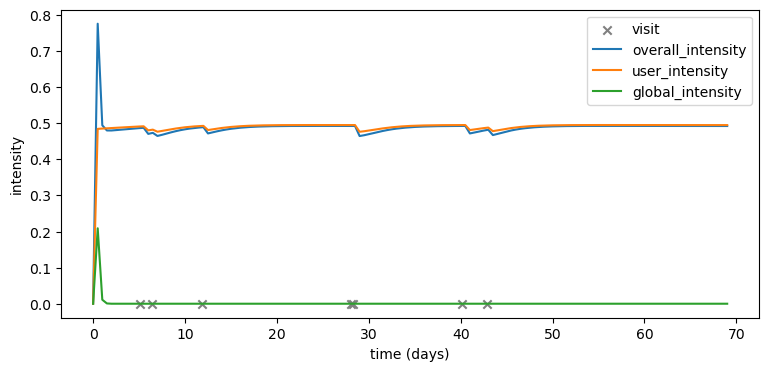

In [ ]:
# conditioned_square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5096]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6996]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6718]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5188]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5774]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.7162]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


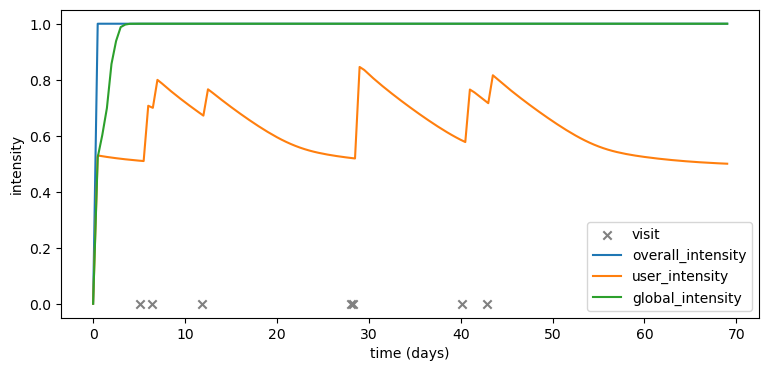

In [ ]:
# negative sampling  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4996]]) 	user_intensity:  tensor([[0.4997]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4962]]) 	user_intensity:  tensor([[0.4975]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4761]]) 	user_intensity:  tensor([[0.4841]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4948]]) 	user_intensity:  tensor([[0.4965]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


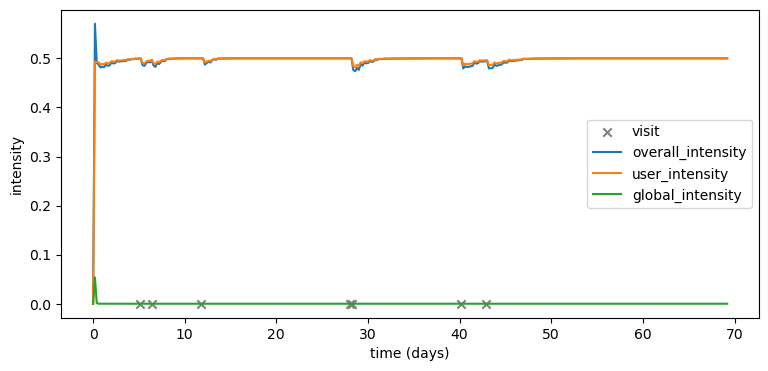

In [ ]:
# square  larger intervals train longer
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.2)

loaded sim_models
total visits for user 12
overall_intensity:  tensor([[0.4660]]) 	user_intensity:  tensor([[0.4773]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4668]]) 	user_intensity:  tensor([[0.4779]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9060]]) 	user_intensity:  tensor([[0.8106]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9868]]) 	user_intensity:  tensor([[0.9322]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


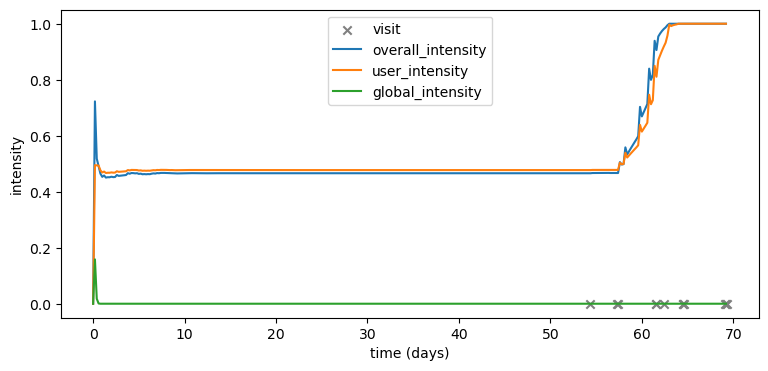

In [ ]:
# square  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1, conditioned=False, increment=.2)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.


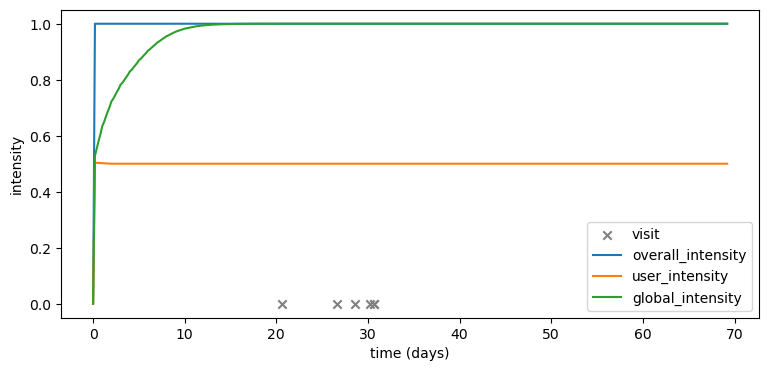

In [ ]:
# square continuous state integral
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=False)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


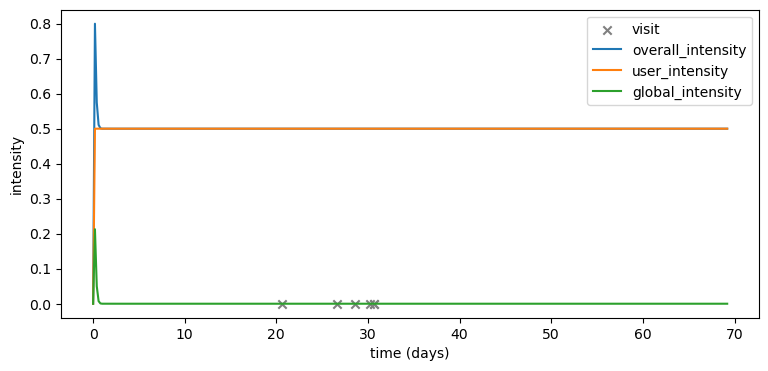

In [ ]:
# negative conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


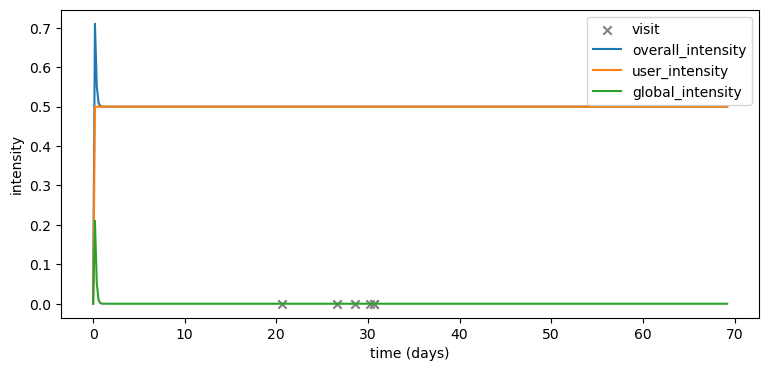

In [ ]:
# square conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


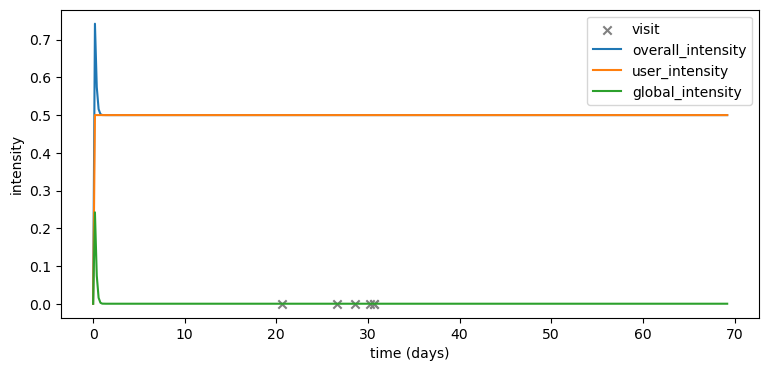

In [ ]:
# square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)

total visits for user 12
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


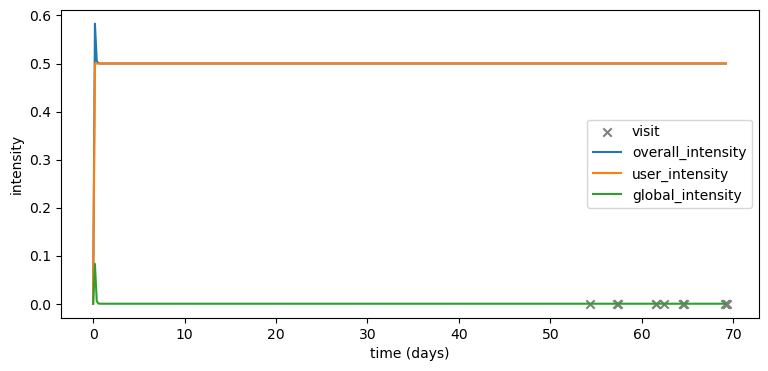

In [ ]:
#negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1)